In [686]:
# processing
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import mode
from scipy.stats import skew
from scipy.stats import kurtosis
from numpy import linalg
from sklearn.ensemble import AdaBoostRegressor
import math
import random
from sklearn.decomposition import PCA
from itertools import product
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

# graphs
from scipy.stats import boxcox

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

# models
from sklearn.cluster import KMeans

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz


from sklearn.linear_model import LogisticRegression

import pickle


# accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit

#display
from IPython.display import Markdown, display
from __future__ import print_function
def printmd(string):
    display(Markdown(string))
np.set_printoptions(threshold=np.nan)
pd.set_option("mode.use_inf_as_na", True)

In [ ]:
dataFile = pd.read_csv("housing_filled.csv")
data = pd.DataFrame(dataFile)
data.dropna(inplace=True)
final_features = []

# <font size = 40 color = blue> KMeans </font>

In [ ]:
X_cluster = pd.DataFrame(data['LotArea'])
X_cluster['OverallCond'] = data['OverallCond']
X_cluster['OverallQual'] = data['OverallQual']
#X_svm['FullBath'] = data['FullBath']
X_cluster['TotRmsAbvGrd'] = data['TotRmsAbvGrd']
#X_cluster['SalePrice'] = data['SalePrice']
#X_svm['GarageArea'] = data['GarageArea']

k_range = np.arange(2,10)
SSE = []
for i in k_range:
    kmeans_model = KMeans(i)
    clusters = kmeans_model.fit_predict(X_cluster)
    SSE.append(kmeans_model.inertia_)

plt.scatter(k_range, SSE)

In [ ]:
kmeans_model = KMeans(4)
clusters = kmeans_model.fit_predict(X_cluster)

plt.title('SalePrice Distribution for each cluster')
plt.scatter(clusters,data['SalePrice'])
"""plt.plot(clusters[0]['OverallCond'],clusters[0]['SalePrice'],'g',
         clusters[1]['OverallCond'],clusters[1]['SalePrice'],'b', 
         clusters[2]['OverallCond'],clusters[2]['SalePrice'],'r',
         clusters[3]['OverallCond'],clusters[3]['SalePrice'],'b')"""
plt.show()

clust_0 = [i for i,d in enumerate(clusters) if d == 0]
clust_1 = [i for i,d in enumerate(clusters) if d == 1]
clust_2 = [i for i,d in enumerate(clusters) if d == 2]
clust_3 = [i for i,d in enumerate(clusters) if d == 3]

plt.title('SalePrice vs. OverallCond')
plt.plot(data.iloc[clust_0]['OverallCond'],data.iloc[clust_0]['SalePrice'],'go',
         data.iloc[clust_1]['OverallCond'],data.iloc[clust_1]['SalePrice'],'bx', 
         data.iloc[clust_2]['OverallCond'],data.iloc[clust_2]['SalePrice'],'ro',
         data.iloc[clust_3]['OverallCond'],data.iloc[clust_3]['SalePrice'],'m^')
plt.show()

plt.title('SalePrice vs. 1stFlrSF')
plt.plot(data.iloc[clust_0]['1stFlrSF'],data.iloc[clust_0]['SalePrice'],'go',
         data.iloc[clust_1]['1stFlrSF'],data.iloc[clust_1]['SalePrice'],'bo', 
         data.iloc[clust_2]['1stFlrSF'],data.iloc[clust_2]['SalePrice'],'ro',
         data.iloc[clust_3]['1stFlrSF'],data.iloc[clust_3]['SalePrice'],'m^')
plt.rcParams['figure.figsize'] = (16, 16)
plt.show()

We decided to cluster using several features that we previously saw had significant relationships with SalePrice. The clustering revealed several unique properties. In the first graph, which shows the distribution of SalePrice within each cluster, indicates that the variables we chose do indeed have a strong relationship with SalePrice; the distributions and means are notably different. The second graph compares SalePrice to one specific feature that was used in our KMeans, OverallCond. It appears that KMeans was able to separate out one cluster that had a large spread in OverallCond and a small spread in SalePrice (primarily in the low range of SalePrice). The third graph looks at two features that were both not included in our KMeans: 1stFlrSF and SalePrice. It appears that 1stFlrSF tends to have a positive relationship with SalePrice; however, that is not true for one cluster. For one cluster, the shape of the points has the shape of an inverse relationship.

In [ ]:
<font color=blue size = 40>**Ensemble (Stacking) Model**</font>

In [ ]:
init_prior = []
data['BldgType'] = LabelEncoder().fit_transform(data['BldgType'])
init_prior.append('OverallQual')
init_prior.append('BldgType')
init_prior.append('TotalBsmtSF')
init_prior.append('1stFlrSF')
init_prior.append('GrLivArea')
init_prior.append('GarageCars')
init_prior.append('GarageArea')
init_prior.append('2ndFlrSF')
init_prior.append('FullBath')
init_prior.append('TotRmsAbvGrd')
init_prior.append('LotArea')
init_prior.append('YearRemodAdd')
init_prior.append('YearBuilt')
init_prior.append('GarageYrBlt')
init_prior.append('FireplaceQu')
init_prior.append('MSSubClass')
init_prior.append('WoodDeckSF')

# eliminate some dependent/redundant features
corr_within_prior = data[init_prior].corr()
for row_name,cols in corr_within_prior.iterrows():
    print(row_name)
    for (name,val) in cols.iteritems():
        if (row_name != name and ((val > 0.6) | (val < -0.6))):
            print("   %s: %0.3f" % (name,val))
    print()

Sets of somewhat correlated variables:

['GarageCars', 'OverallQual', 'GarageArea']


['TotalBsmtSF', '1stFlrSF']


['GrLivArea', '2ndFlrSF', 'FullBath', 'TotRmsAbvGrd']


['GarageYrBlt', 'YearRemodAdd', 'YearBuilt']


# <font size=40> **Feature Selection** </font>

In [590]:
new_prior = list(init_prior)
names = ['Garage','LowerSF','Living','Year']
new_prior.extend(names)
for dependents in [['GarageCars', 'OverallQual', 'GarageArea'],['TotalBsmtSF','1stFlrSF'],
                  ['GrLivArea', '2ndFlrSF', 'FullBath', 'TotRmsAbvGrd'],['GarageYrBlt', 'YearRemodAdd', 'YearBuilt']]:
    pca = PCA(1).fit(data[dependents])
    factors = pca.components_
    data[names.pop()] = np.sum(np.multiply(factors, data[dependents]),axis=1)
    #plt.bar(np.arrange(len(dependents)),pca.explained_variance_ratio_)
    #plt.xticks(np.arrange(len(dependents)),dependents)
    #plt.title('Fraction of Variance Explained by Each Component')
    #plt.xlabel('Component')
    #plt.ylabel('Fraction of Total Variance')
    #plt.show()
    for i in dependents:
        new_prior.remove(i)
print(new_prior)

['BldgType', 'LotArea', 'FireplaceQu', 'MSSubClass', 'WoodDeckSF', 'Garage', 'LowerSF', 'Living', 'Year']


In [591]:
sale_corr = data.corr()['SalePrice']
sale_corr.drop('SalePrice')
display(Markdown("**Correlation with SalePrice**"))
display(sale_corr[new_prior])

**Correlation with SalePrice**

BldgType      -0.080525
LotArea        0.263939
FireplaceQu    0.334950
MSSubClass    -0.083768
WoodDeckSF     0.317165
Garage        -0.552930
LowerSF        0.602201
Living         0.629331
Year           0.622061
Name: SalePrice, dtype: float64

In [592]:
new_prior_2 = list(new_prior)
new_prior_2.remove('BldgType')
new_prior_2.remove('LotArea')
new_prior_2.remove('FireplaceQu')
new_prior_2.remove('MSSubClass')
new_prior_2.remove('WoodDeckSF')
display(new_prior_2)

['Garage', 'LowerSF', 'Living', 'Year']

# <font size=40>**Preprocessing**</font>

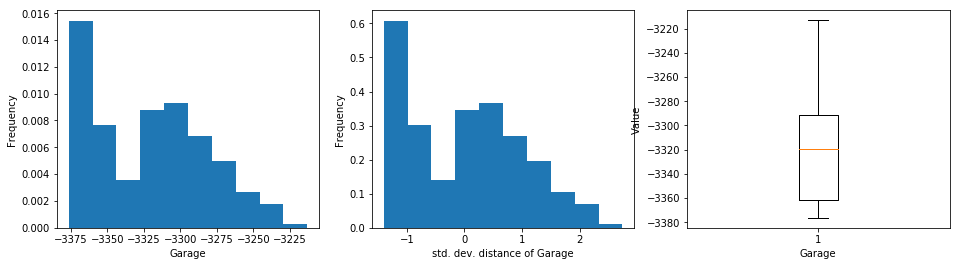

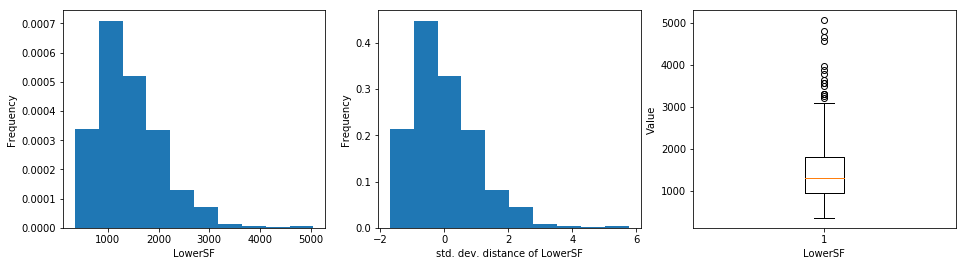

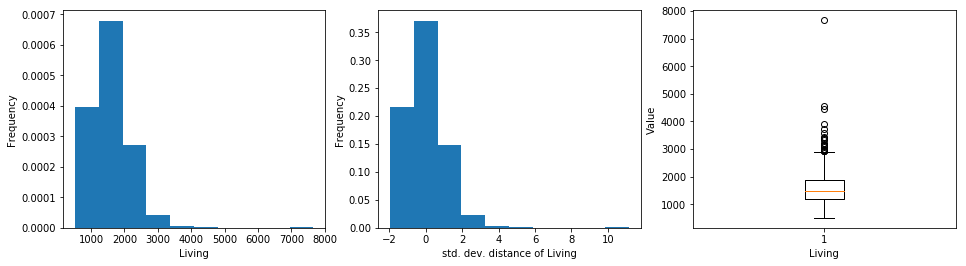

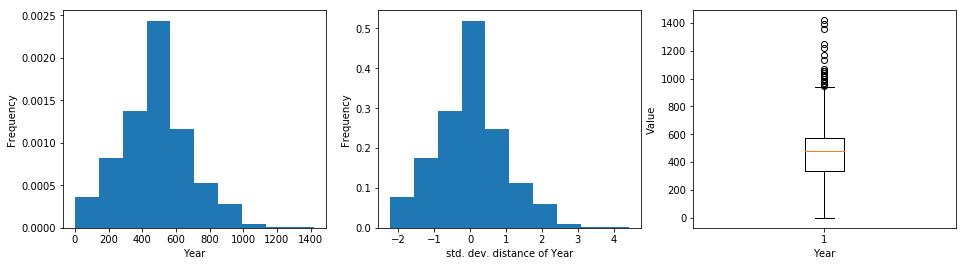

In [593]:
plt.rcParams['figure.figsize'] = (16,4)
for feature_name in new_prior_2:
    plt.title(feature_name)
    plt.subplot(1, 3, 1)
    plt.hist(data[feature_name],density=True)
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    
    stdev = np.std(data[feature_name])
    mean = np.mean(data[feature_name])
    col_distr = ((data[feature_name] - mean) / stdev)
    plt.subplot(1, 3, 2)
    plt.hist(col_distr,density=True)
    plt.xlabel('std. dev. distance of ' + feature_name)
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.boxplot(data[feature_name])
    plt.xlabel(feature_name)
    plt.ylabel('Value')

    plt.show()

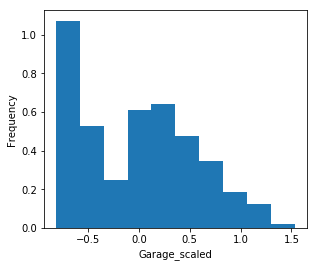

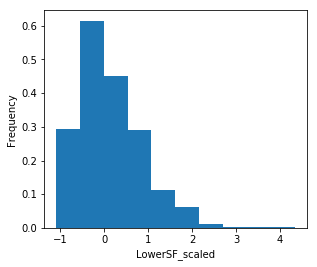

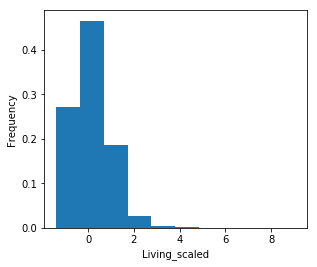

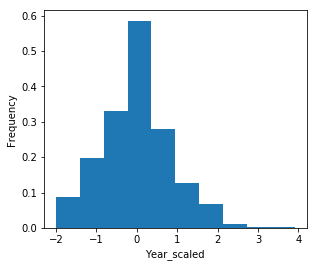

In [594]:
scaler = RobustScaler()
data["Garage_scaled"] = scaler.fit_transform(data['Garage'].values.reshape(-1,1))
data["LowerSF_scaled"] = scaler.fit_transform(data['LowerSF'].values.reshape(-1,1))
data["Living_scaled"] = scaler.fit_transform(data['Living'].values.reshape(-1,1))
data["Year_scaled"] = scaler.fit_transform(data['Year'].values.reshape(-1,1))
for feature_name in new_prior_2:
    plt.title(feature_name + "_scaled")
    plt.subplot(1, 3, 1)
    plt.hist(data[feature_name + "_scaled"],density=True)
    plt.xlabel(feature_name + "_scaled")
    plt.ylabel('Frequency')
    plt.show()

In [685]:
final_features = ['Garage_scaled','LowerSF_scaled','Living_scaled','Year_scaled']

# <font size = 40> Clustering Algorithm for part of Stack </font>

In [739]:
 def cluster_from_stack_of_KMeans(data, K=8, num_weak_learners = 5,num_neighbors=1,
                            distance_penalty= lambda x: x):
    
    assert K < len(data)
    assert num_neighbors <= len(data)
    
    C = np.empty((num_weak_learners,data.shape[0]))
    SSE = np.empty((num_weak_learners,))
    for iter_num in range(num_weak_learners):
        clustering = KMeans(K,init='random', n_init=1, n_jobs=-1)
        clustering.fit(data)
        #np.put(C,[iter_num,],clustering.labels_)
        C[iter_num] = clustering.labels_
        SSE[iter_num] = clustering.inertia_
            
            
            
            
    # calculate node connections
    
    C_scores = distance_penalty((1 - SSE)/ np.max(SSE)) 
   
    connections = [[] for _ in range(len(data))]
    for i in range(len(connections)):
        connections[i] = np.argsort([np.sum([d for iter_num,d in enumerate(C_scores) if
                                         i != j and C[iter_num][i] == C[iter_num][j]])
                                   for j in range(len(data))])[-num_neighbors:]
        for _ in range(num_neighbors-1):
            if np.random.ranf() > 0.7:
                connections[i] = connections[i][:-1]
        
    # group together linked nodes to form (unequal) clusters
    
    cluster_sets = []
    cluster_dict = {} # set of (element index -> index in clusters)
    to_merge = {} # lowest cluster_set index in sets to be merged -> the rest of the sets that should be merged together
    #to_merge_not_keys = set()
    for i1,links in enumerate(connections):
        for i2 in links:
            if i2 not in cluster_dict:
                if i1 in cluster_dict:
                    c = cluster_dict[i1]
                    cluster_sets[c].add(i2)
                    cluster_dict[i2]= c
                else:
                    cluster_sets.append({i1,i2})
                    cluster_dict.update({i1 : len(cluster_sets)-1, i2 : len(cluster_sets)-1})
            else:
                if i1 in cluster_dict:
                    in_to_merge = 0
                    temp_key = None
                    for merge_key,merge_set in to_merge.items():
                        if in_to_merge != 1 and (cluster_dict[i1] in merge_set or cluster_dict[i1] == merge_key):
                            if in_to_merge == 0:
                                in_to_merge = 1
                                temp_key = merge_key
                            else:
                                merge_set.add(merge_key)
                                to_merge[temp_key].add(merge_key)
                                comb = merge_set.union(to_merge[temp_key])
                                comb.add(cluster_dict[i2])
                                comb.add(cluster_dict[i1])
                                min_key = min(comb)
                                comb.remove(min_key)
                                to_merge.update({min_key:comb})
                                del to_merge[merge_key]
                                del to_merge[temp_key]
                                in_to_merge=3
                                break
                        elif in_to_merge != 2 and (cluster_dict[i2] in merge_set or cluster_dict[i2] == merge_key):
                            if in_to_merge == 0:
                                in_to_merge = 2
                                temp_key = merge_key
                            else:
                                merge_set.add(merge_key)
                                to_merge[temp_key].add(merge_key)
                                comb = merge_set.union(to_merge[temp_key])
                                comb.add(cluster_dict[i2])
                                comb.add(cluster_dict[i1])
                                min_key = min(comb)
                                comb.remove(min_key)
                                to_merge.update({min_key:comb})
                                del to_merge[merge_key]
                                del to_merge[temp_key]
                                in_to_merge=3
                                break 
                    if in_to_merge==1:
                        if cluster_dict[i2] > temp_key:
                            to_merge[temp_key].add(cluster_dict[i2])
                        else:
                            to_merge[temp_key].add(temp_key)
                            to_merge.update({cluster_dict[i2]:to_merge[temp_key]})
                            del to_merge[temp_key]
                    elif in_to_merge==2:
                        if cluster_dict[i1] > temp_key:
                            to_merge[temp_key].add(cluster_dict[i1])
                        else:
                            to_merge[temp_key].add(temp_key)
                            to_merge.update({cluster_dict[i1]:to_merge[temp_key]})
                            del to_merge[temp_key]
                    elif in_to_merge==0:
                        if cluster_dict[i1] < cluster_dict[i2]:
                            to_merge.update({cluster_dict[i1]:{cluster_dict[i2]}})
                        else:
                            to_merge.update({cluster_dict[i2]:{cluster_dict[i1]}})
                        #to_merge_not_keys.add(i2)
                else:
                    c = cluster_dict[i2]
                    cluster_dict[i1] = c
                    cluster_sets[c].add(i1)
    
    combined_clusters = set()
    for i,c_set in enumerate(cluster_sets):
        if c_set is not None:
            if i not in to_merge:
                combined_clusters.add(frozenset(c_set))
            else:
                total_set = c_set
                for cluster_sets_index in to_merge[i]:
                    total_set = total_set.union(cluster_sets[cluster_sets_index])
                    cluster_sets[cluster_sets_index] = None
                combined_clusters.add(frozenset(total_set))
    return combined_clusters

# Finding Stable Parameters for clustering

In [740]:
k_ticks = [3,7,20]
w_ticks = [5,20]
n_ticks = [1,2,3]

def sample_clustering_params():
    cluster_sizes = {}
    for k in k_ticks:
        for w in w_ticks: 
            for n in n_ticks:
                c_sizes = []
                for i in range(5):
                    train, valid, _, _ = train_test_split(
                                        data[final_features],data['SalePrice'],test_size=0.2)
                    clusters = cluster_from_stack_of_KMeans(train, K=k, num_weak_learners=w, num_neighbors=n)
                    temp = []
                    for c in clusters:
                        temp.append(len(c))
                    c_sizes.append(temp)
                    print('          ...')
                cluster_sizes[(k,w,n)]= c_sizes
                print("----------" + str(n))
                print(cluster_sizes)
            print("----" + str(w))
        print(k)
    return cluster_sizes

In [741]:
cluster_sizes = sample_clustering_params()

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]]}
          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]], (3, 5, 2): [[1, 65, 1067, 2, 1], [31, 126, 1, 6, 102, 3, 122, 94, 6, 278, 2, 176, 4, 185], [39, 1, 46, 55, 668, 43, 5, 65, 112, 101, 1], [696, 1, 7, 39, 1, 3, 2, 92, 2, 108, 17, 166, 1, 1], [64, 358, 29, 179, 57, 7, 2, 8, 181, 10, 82, 157, 2]]}
          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]], (3, 5, 2): [[1, 65, 1067, 2, 1], [31, 126, 1, 6, 102, 3, 122, 94, 6, 278, 2, 176, 4, 185], [39, 1, 46, 55, 668, 43, 

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]], (3, 5, 2): [[1, 65, 1067, 2, 1], [31, 126, 1, 6, 102, 3, 122, 94, 6, 278, 2, 176, 4, 185], [39, 1, 46, 55, 668, 43, 5, 65, 112, 101, 1], [696, 1, 7, 39, 1, 3, 2, 92, 2, 108, 17, 166, 1, 1], [64, 358, 29, 179, 57, 7, 2, 8, 181, 10, 82, 157, 2]], (3, 5, 3): [[72, 191, 4, 22, 2, 2, 79, 51, 4, 84, 38, 5, 7, 17, 4, 4, 403, 145, 2], [1, 88, 11, 5, 36, 448, 530, 17], [142, 3, 53, 4, 6, 200, 55, 16, 5, 46, 2, 46, 1, 2, 137, 1, 11, 3, 403], [181, 108, 117, 2, 254, 7, 2, 75, 6, 85, 231, 68], [87, 3, 1, 754, 4, 75, 2, 33, 6, 153, 6, 2, 10]], (3, 20, 1): [[1, 1, 1, 1, 1, 4, 1, 1, 1125], [3, 153, 2, 1, 5, 5, 967], [2, 2, 2, 24, 2, 139, 897, 68], [1, 1135], [1, 1, 1, 1, 1132]], (3, 20, 2): [[10, 10, 252, 78, 381, 10, 3, 1, 2, 131, 4, 40, 11, 1, 5, 47, 7, 2, 15, 126], [23, 56, 5, 2, 15, 5, 9

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]], (3, 5, 2): [[1, 65, 1067, 2, 1], [31, 126, 1, 6, 102, 3, 122, 94, 6, 278, 2, 176, 4, 185], [39, 1, 46, 55, 668, 43, 5, 65, 112, 101, 1], [696, 1, 7, 39, 1, 3, 2, 92, 2, 108, 17, 166, 1, 1], [64, 358, 29, 179, 57, 7, 2, 8, 181, 10, 82, 157, 2]], (3, 5, 3): [[72, 191, 4, 22, 2, 2, 79, 51, 4, 84, 38, 5, 7, 17, 4, 4, 403, 145, 2], [1, 88, 11, 5, 36, 448, 530, 17], [142, 3, 53, 4, 6, 200, 55, 16, 5, 46, 2, 46, 1, 2, 137, 1, 11, 3, 403], [181, 108, 117, 2, 254, 7, 2, 75, 6, 85, 231, 68], [87, 3, 1, 754, 4, 75, 2, 33, 6, 153, 6, 2, 10]], (3, 20, 1): [[1, 1, 1, 1, 1, 4, 1, 1, 1125], [3, 153, 2, 1, 5, 5, 967], [2, 2, 2, 24, 2, 139, 897, 68], [1, 1135], [1, 1, 1, 1, 1132]], (3, 20, 2): [[10, 10, 252, 78, 381, 10, 3, 1, 2, 131, 4, 40, 11, 1, 5, 47, 7, 2, 15, 126], [23, 56, 5, 2, 15, 5, 9

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]], (3, 5, 2): [[1, 65, 1067, 2, 1], [31, 126, 1, 6, 102, 3, 122, 94, 6, 278, 2, 176, 4, 185], [39, 1, 46, 55, 668, 43, 5, 65, 112, 101, 1], [696, 1, 7, 39, 1, 3, 2, 92, 2, 108, 17, 166, 1, 1], [64, 358, 29, 179, 57, 7, 2, 8, 181, 10, 82, 157, 2]], (3, 5, 3): [[72, 191, 4, 22, 2, 2, 79, 51, 4, 84, 38, 5, 7, 17, 4, 4, 403, 145, 2], [1, 88, 11, 5, 36, 448, 530, 17], [142, 3, 53, 4, 6, 200, 55, 16, 5, 46, 2, 46, 1, 2, 137, 1, 11, 3, 403], [181, 108, 117, 2, 254, 7, 2, 75, 6, 85, 231, 68], [87, 3, 1, 754, 4, 75, 2, 33, 6, 153, 6, 2, 10]], (3, 20, 1): [[1, 1, 1, 1, 1, 4, 1, 1, 1125], [3, 153, 2, 1, 5, 5, 967], [2, 2, 2, 24, 2, 139, 897, 68], [1, 1135], [1, 1, 1, 1, 1132]], (3, 20, 2): [[10, 10, 252, 78, 381, 10, 3, 1, 2, 131, 4, 40, 11, 1, 5, 47, 7, 2, 15, 126], [23, 56, 5, 2, 15, 5, 9

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]], (3, 5, 2): [[1, 65, 1067, 2, 1], [31, 126, 1, 6, 102, 3, 122, 94, 6, 278, 2, 176, 4, 185], [39, 1, 46, 55, 668, 43, 5, 65, 112, 101, 1], [696, 1, 7, 39, 1, 3, 2, 92, 2, 108, 17, 166, 1, 1], [64, 358, 29, 179, 57, 7, 2, 8, 181, 10, 82, 157, 2]], (3, 5, 3): [[72, 191, 4, 22, 2, 2, 79, 51, 4, 84, 38, 5, 7, 17, 4, 4, 403, 145, 2], [1, 88, 11, 5, 36, 448, 530, 17], [142, 3, 53, 4, 6, 200, 55, 16, 5, 46, 2, 46, 1, 2, 137, 1, 11, 3, 403], [181, 108, 117, 2, 254, 7, 2, 75, 6, 85, 231, 68], [87, 3, 1, 754, 4, 75, 2, 33, 6, 153, 6, 2, 10]], (3, 20, 1): [[1, 1, 1, 1, 1, 4, 1, 1, 1125], [3, 153, 2, 1, 5, 5, 967], [2, 2, 2, 24, 2, 139, 897, 68], [1, 1135], [1, 1, 1, 1, 1132]], (3, 20, 2): [[10, 10, 252, 78, 381, 10, 3, 1, 2, 131, 4, 40, 11, 1, 5, 47, 7, 2, 15, 126], [23, 56, 5, 2, 15, 5, 9

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[718, 418], [347, 789], [1, 34, 4, 10, 1, 225, 3, 724, 134], [1, 1, 1, 66, 4, 1, 1, 1, 215, 69, 757, 13, 6], [1136]], (3, 5, 2): [[1, 65, 1067, 2, 1], [31, 126, 1, 6, 102, 3, 122, 94, 6, 278, 2, 176, 4, 185], [39, 1, 46, 55, 668, 43, 5, 65, 112, 101, 1], [696, 1, 7, 39, 1, 3, 2, 92, 2, 108, 17, 166, 1, 1], [64, 358, 29, 179, 57, 7, 2, 8, 181, 10, 82, 157, 2]], (3, 5, 3): [[72, 191, 4, 22, 2, 2, 79, 51, 4, 84, 38, 5, 7, 17, 4, 4, 403, 145, 2], [1, 88, 11, 5, 36, 448, 530, 17], [142, 3, 53, 4, 6, 200, 55, 16, 5, 46, 2, 46, 1, 2, 137, 1, 11, 3, 403], [181, 108, 117, 2, 254, 7, 2, 75, 6, 85, 231, 68], [87, 3, 1, 754, 4, 75, 2, 33, 6, 153, 6, 2, 10]], (3, 20, 1): [[1, 1, 1, 1, 1, 4, 1, 1, 1125], [3, 153, 2, 1, 5, 5, 967], [2, 2, 2, 24, 2, 139, 897, 68], [1, 1135], [1, 1, 1, 1, 1132]], (3, 20, 2): [[10, 10, 252, 78, 381, 10, 3, 1, 2, 131, 4, 40, 11, 1, 5, 47, 7, 2, 15, 126], [23, 56, 5, 2, 15, 5, 9

In [ ]:
temp = cluster_sizes

In [692]:
other = sample_clustering_params()

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]]}
          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]]}
          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 6

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89, 219, 1, 8, 210, 134], [6, 1, 542, 3, 130

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------1
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------2
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------3
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

          ...
          ...
          ...
          ...
          ...
----------6
{(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89

In [690]:
# data from runnning sample_clustering_params 
cluster_sizes={(3, 5, 1): [[1136], [9, 1041, 81, 5], [1, 292, 842, 1], [1, 2, 382, 751], [6, 4, 2, 13, 1111]], (3, 5, 2): [[2, 3, 9, 11, 54, 9, 520, 4, 43, 28, 1, 54, 36, 290, 1, 70, 1], [436, 302, 7, 1, 1, 142, 53, 95, 30, 7, 5, 57], [12, 12, 2, 4, 3, 23, 65, 2, 99, 84, 61, 2, 75, 207, 2, 346, 2, 2, 124, 2, 7], [166, 3, 112, 260, 25, 1, 2, 377, 50, 5, 53, 30, 8, 2, 42], [72, 619, 1, 120, 17, 4, 2, 5, 296]], (3, 5, 3): [[72, 5, 3, 1, 513, 1, 534, 1, 6], [246, 1, 362, 88, 432, 3, 4], [40, 2, 318, 1, 6, 73, 133, 36, 1, 15, 1, 1, 1, 148, 21, 3, 1, 3, 7, 230, 2, 1, 87, 4, 1], [671, 11, 278, 3, 9, 67, 93, 4], [4, 235, 9, 4, 111, 2, 10, 6, 3, 83, 4, 1, 1, 31, 321, 1, 4, 15, 1, 1, 166, 53, 6, 1, 3, 23, 37]], (3, 5, 6): [[17, 11, 115, 7, 74, 62, 40, 1, 1, 101, 240, 1, 118, 348], [13, 130, 245, 12, 24, 92, 4, 269, 137, 64, 146], [6, 15, 41, 314, 20, 1, 11, 207, 65, 12, 10, 6, 183, 88, 144, 13], [60, 9, 5, 188, 191, 1, 14, 7, 89, 219, 1, 8, 210, 134], [6, 1, 542, 3, 130, 81, 18, 11, 344]], (3, 20, 1): [[1134, 1, 1], [691, 2, 4, 439], [1134, 1, 1], [2, 708, 11, 7, 2, 406], [11, 1, 75, 687, 3, 20, 3, 37, 1, 151, 1, 7, 1, 112, 7, 19]], (3, 20, 2): [[83, 6, 3, 2, 3, 2, 118, 1, 268, 1, 133, 2, 94, 114, 50, 3, 8, 2, 2, 239, 2], [94, 5, 1, 12, 2, 4, 1, 693, 16, 1, 72, 46, 1, 1, 9, 121, 57], [3, 2, 8, 13, 4, 4, 2, 85, 5, 250, 7, 4, 106, 37, 63, 92, 20, 3, 2, 392, 18, 16], [93, 4, 106, 2, 2, 307, 3, 3, 49, 2, 22, 1, 4, 7, 50, 2, 1, 2, 24, 3, 49, 58, 116, 151, 2, 3, 68, 2], [75, 61, 7, 88, 1, 1, 6, 2, 15, 6, 8, 75, 2, 38, 7, 17, 2, 2, 121, 8, 3, 3, 171, 6, 83, 275, 53]], (3, 20, 3): [[3, 4, 1, 1, 4, 96, 1, 1, 149, 3, 598, 3, 46, 2, 17, 102, 1, 3, 3, 8, 6, 73, 6, 1, 4], [652, 7, 15, 3, 7, 2, 3, 81, 60, 15, 6, 52, 3, 1, 50, 7, 1, 1, 1, 4, 13, 23, 10, 8, 111], [3, 105, 3, 6, 4, 4, 1, 27, 84, 5, 3, 44, 53, 1, 442, 169, 4, 4, 18, 5, 3, 6, 2, 95, 35, 4, 6], [5, 8, 18, 104, 7, 3, 4, 57, 5, 41, 1, 22, 3, 1, 21, 53, 11, 19, 9, 72, 8, 33, 306, 174, 6, 145], [127, 3, 2, 126, 4, 81, 4, 4, 26, 5, 16, 270, 28, 50, 1, 228, 161]], (3, 20, 6): [[326, 8, 6, 23, 39, 1, 10, 99, 1, 1, 401, 11, 7, 1, 17, 34, 151], [2, 8, 12, 2, 177, 33, 5, 50, 1, 132, 4, 220, 7, 4, 5, 125, 1, 348], [5, 315, 4, 9, 6, 2, 173, 7, 186, 68, 14, 7, 37, 25, 7, 194, 77], [8, 30, 4, 119, 34, 6, 27, 40, 14, 112, 9, 164, 316, 12, 241], [7, 1, 85, 8, 12, 3, 328, 176, 4, 11, 128, 102, 10, 10, 16, 84, 14, 124, 5, 7, 1]], (3, 40, 1): [[542, 2, 6, 3, 142, 4, 3, 19, 1, 13, 401], [9, 4, 2, 392, 2, 5, 6, 2, 714], [147, 18, 860, 2, 109], [904, 1, 1, 81, 102, 7, 2, 3, 2, 1, 17, 3, 2, 1, 1, 8], [13, 2, 1, 2, 1114, 2, 2]], (3, 40, 2): [[3, 3, 8, 5, 56, 29, 9, 2, 3, 458, 194, 4, 1, 3, 9, 1, 97, 3, 105, 7, 28, 32, 42, 2, 2, 3, 3, 3, 21], [228, 7, 5, 3, 54, 1, 533, 2, 4, 3, 3, 21, 170, 2, 2, 14, 1, 64, 3, 16], [55, 1, 2, 1, 1, 2, 54, 4, 207, 19, 8, 16, 2, 4, 36, 3, 145, 8, 251, 24, 141, 2, 1, 2, 3, 19, 11, 4, 2, 6, 6, 3, 2, 4, 41, 2, 7, 22, 2, 3, 6, 4], [4, 10, 66, 17, 6, 93, 227, 66, 125, 20, 41, 2, 2, 27, 4, 135, 2, 5, 3, 3, 4, 8, 46, 3, 177, 9, 7, 3, 21], [2, 16, 4, 3, 1, 4, 2, 11, 8, 3, 183, 70, 141, 11, 3, 67, 4, 2, 2, 3, 3, 570, 23]], (3, 40, 3): [[26, 13, 40, 26, 1, 3, 4, 5, 37, 2, 101, 32, 6, 93, 3, 2, 4, 1, 1, 4, 6, 106, 538, 1, 1, 6, 4, 4, 66], [1, 1, 4, 58, 5, 35, 165, 24, 331, 39, 42, 109, 3, 2, 2, 7, 1, 5, 1, 4, 111, 4, 4, 2, 16, 81, 6, 1, 72], [2, 4, 79, 3, 112, 120, 12, 20, 6, 1, 1, 1, 50, 28, 1, 5, 162, 1, 60, 162, 306], [3, 1, 3, 4, 5, 2, 2, 3, 113, 421, 25, 4, 114, 55, 122, 4, 6, 70, 166, 13], [166, 13, 31, 10, 36, 89, 2, 1, 1, 3, 6, 45, 1, 5, 262, 52, 91, 1, 1, 5, 223, 46, 8, 1, 4, 6, 3, 24]], (3, 40, 6): [[187, 228, 12, 57, 7, 1, 331, 16, 209, 88], [1, 136, 10, 95, 215, 11, 51, 38, 6, 107, 230, 55, 5, 1, 1, 156, 1, 17], [102, 20, 4, 5, 5, 365, 10, 13, 14, 15, 148, 168, 15, 6, 28, 39, 25, 5, 1, 3, 7, 1, 104, 33], [841, 4, 22, 85, 35, 8, 7, 6, 51, 1, 74, 1, 1], [7, 6, 112, 68, 1, 8, 1, 6, 12, 13, 7, 76, 1, 11, 2, 154, 1, 5, 338, 205, 8, 1, 1, 2, 50, 1, 1, 38]], (7, 5, 1): [[431, 705], [1136], [1010, 126], [5, 1131], [342, 794]], (7, 5, 2): [[33, 3, 16, 4, 2, 25, 1, 8, 3, 4, 211, 3, 2, 9, 20, 394, 5, 8, 165, 4, 12, 104, 14, 69, 2, 3, 9, 3], [9, 2, 2, 2, 64, 33, 6, 4, 2, 26, 43, 2, 2, 2, 3, 40, 39, 6, 9, 201, 3, 9, 2, 8, 26, 2, 2, 6, 49, 2, 9, 8, 2, 64, 18, 50, 269, 2, 2, 13, 2, 89, 2], [45, 28, 6, 2, 5, 4, 4, 4, 116, 237, 4, 210, 20, 2, 53, 135, 3, 2, 47, 4, 127, 1, 6, 1, 2, 12, 41, 2, 10, 1, 2], [3, 3, 85, 2, 221, 2, 2, 1, 155, 169, 60, 4, 5, 1, 67, 3, 2, 5, 4, 48, 11, 2, 26, 11, 2, 1, 62, 32, 6, 76, 65], [3, 50, 2, 238, 11, 2, 30, 2, 68, 57, 8, 31, 13, 7, 30, 15, 137, 70, 191, 4, 9, 7, 28, 31, 3, 23, 4, 8, 26, 5, 6, 13, 4]], (7, 5, 3): [[81, 18, 10, 49, 24, 113, 109, 3, 4, 27, 3, 3, 145, 6, 43, 4, 311, 116, 8, 2, 2, 3, 52], [11, 10, 8, 3, 6, 157, 166, 4, 63, 7, 7, 1, 99, 32, 20, 12, 12, 4, 16, 5, 7, 73, 148, 265], [6, 17, 24, 26, 14, 147, 23, 52, 151, 75, 91, 4, 5, 3, 24, 5, 4, 7, 8, 12, 4, 4, 140, 90, 3, 37, 3, 101, 9, 41, 6], [3, 13, 1, 3, 23, 2, 368, 41, 5, 116, 13, 4, 3, 67, 3, 8, 26, 3, 310, 111, 7, 4, 2], [2, 51, 3, 4, 106, 6, 3, 33, 14, 1, 18, 85, 16, 28, 11, 8, 12, 101, 57, 5, 15, 44, 129, 3, 63, 2, 5, 48, 3, 8, 128, 42, 82]], (7, 5, 6): [[61, 1, 11, 11, 6, 9, 346, 42, 14, 6, 157, 4, 154, 12, 9, 20, 85, 117, 9, 62], [10, 12, 7, 35, 227, 8, 7, 6, 5, 96, 6, 5, 14, 11, 222, 44, 4, 78, 71, 268], [45, 8, 46, 2, 5, 98, 65, 24, 4, 3, 50, 109, 41, 5, 246, 20, 6, 5, 124, 6, 7, 180, 10, 21, 6], [5, 7, 46, 125, 3, 104, 9, 164, 19, 68, 47, 60, 1, 179, 36, 30, 66, 56, 111], [28, 12, 15, 195, 181, 86, 43, 221, 350, 5]], (7, 20, 1): [[1123, 13], [242, 894], [1046, 90], [380, 756], [280, 854, 2]], (7, 20, 2): [[4, 6, 140, 87, 17, 82, 2, 2, 4, 17, 4, 139, 15, 4, 35, 2, 1, 41, 23, 4, 2, 4, 2, 3, 40, 12, 5, 3, 11, 2, 3, 4, 2, 3, 62, 4, 2, 3, 3, 6, 2, 4, 27, 2, 11, 11, 128, 43, 15, 3, 4, 2, 11, 3, 8, 4, 2, 4, 3, 21, 23], [11, 146, 131, 8, 2, 9, 16, 3, 2, 23, 25, 43, 3, 2, 2, 34, 7, 12, 14, 44, 13, 40, 5, 3, 2, 4, 12, 4, 2, 5, 7, 20, 4, 2, 2, 3, 3, 7, 6, 2, 4, 42, 6, 3, 3, 2, 3, 12, 3, 2, 5, 6, 11, 2, 3, 2, 2, 44, 11, 2, 4, 2, 72, 12, 9, 20, 34, 19, 18, 2, 53, 21, 16, 3], [5, 4, 18, 5, 3, 6, 4, 2, 3, 3, 91, 4, 5, 8, 18, 2, 1, 28, 2, 3, 193, 17, 15, 2, 7, 2, 2, 2, 103, 12, 9, 4, 2, 4, 38, 2, 23, 4, 3, 12, 2, 23, 3, 3, 4, 64, 44, 12, 4, 52, 3, 8, 2, 77, 2, 22, 3, 2, 4, 4, 27, 24, 23, 4, 7, 2, 23, 13, 4], [19, 53, 4, 4, 43, 72, 10, 28, 12, 4, 66, 23, 5, 2, 2, 3, 10, 2, 2, 2, 4, 47, 3, 23, 4, 3, 2, 20, 50, 6, 4, 3, 5, 2, 4, 7, 17, 2, 1, 2, 20, 5, 4, 2, 2, 11, 5, 5, 12, 2, 4, 20, 3, 9, 2, 72, 3, 14, 27, 3, 10, 3, 4, 2, 3, 2, 2, 308, 2], [2, 2, 2, 2, 23, 42, 2, 5, 2, 3, 3, 2, 48, 2, 4, 27, 5, 3, 65, 25, 16, 110, 4, 1, 2, 2, 47, 2, 5, 2, 2, 15, 19, 19, 101, 12, 4, 2, 2, 19, 47, 2, 4, 5, 4, 2, 73, 26, 4, 11, 19, 2, 11, 3, 2, 2, 3, 73, 2, 4, 3, 51, 3, 7, 3, 15, 21, 2, 11, 64, 2]], (7, 20, 3): [[167, 82, 27, 21, 6, 20, 3, 17, 4, 10, 22, 27, 4, 5, 39, 88, 24, 92, 3, 2, 3, 3, 29, 9, 16, 5, 72, 3, 27, 8, 19, 4, 3, 3, 6, 4, 64, 5, 4, 6, 3, 54, 10, 6, 51, 8, 38, 10], [6, 2, 1, 3, 70, 2, 104, 3, 3, 43, 5, 50, 4, 33, 10, 7, 2, 15, 9, 3, 36, 3, 5, 58, 11, 7, 4, 5, 4, 138, 13, 3, 14, 11, 47, 3, 1, 3, 29, 16, 8, 40, 127, 148, 2, 20, 5], [20, 2, 2, 5, 1, 4, 23, 138, 3, 9, 67, 32, 8, 7, 5, 3, 8, 6, 63, 7, 1, 2, 73, 58, 6, 8, 2, 36, 53, 4, 81, 23, 26, 1, 5, 5, 7, 26, 3, 11, 4, 3, 3, 5, 1, 47, 91, 58, 10, 7, 27, 4, 32], [3, 4, 3, 72, 73, 18, 12, 12, 22, 11, 60, 86, 3, 8, 9, 32, 25, 9, 8, 7, 16, 4, 6, 49, 2, 11, 66, 24, 13, 348, 2, 15, 5, 94, 4], [5, 1, 48, 2, 3, 6, 12, 3, 4, 5, 5, 89, 41, 10, 5, 24, 4, 4, 32, 2, 18, 30, 6, 2, 4, 50, 2, 59, 116, 5, 9, 6, 6, 2, 3, 10, 26, 18, 10, 8, 3, 48, 8, 3, 6, 14, 10, 4, 16, 3, 7, 46, 3, 30, 14, 10, 85, 11, 19, 3, 16, 58, 4, 20]], (7, 20, 6): [[18, 20, 7, 63, 9, 59, 251, 146, 4, 14, 7, 3, 24, 85, 6, 65, 6, 3, 5, 8, 13, 8, 19, 5, 6, 5, 41, 5, 27, 7, 145, 26, 9, 5, 6, 6], [6, 19, 123, 22, 42, 6, 45, 15, 3, 31, 18, 175, 14, 20, 11, 21, 216, 1, 7, 6, 109, 12, 6, 12, 5, 6, 5, 9, 3, 90, 4, 16, 58], [7, 12, 7, 15, 8, 5, 5, 7, 6, 7, 4, 20, 7, 8, 6, 72, 37, 8, 91, 30, 5, 58, 285, 3, 6, 6, 5, 21, 87, 3, 12, 113, 74, 17, 6, 6, 7, 5, 55], [16, 61, 8, 169, 8, 5, 4, 4, 13, 56, 4, 8, 38, 16, 3, 62, 21, 2, 80, 29, 93, 44, 3, 6, 3, 29, 9, 5, 8, 7, 38, 19, 6, 16, 19, 40, 110, 9, 19, 20, 19, 7], [91, 8, 7, 1, 24, 9, 86, 7, 12, 6, 174, 138, 34, 4, 4, 4, 20, 15, 57, 4, 26, 33, 10, 6, 7, 7, 4, 47, 57, 61, 173]], (7, 40, 1): [[7, 3, 952, 160, 5, 2, 7], [1136], [1136], [2, 3, 5, 39, 834, 2, 52, 2, 2, 5, 188, 2], [976, 158, 2]], (7, 40, 2): [[4, 12, 23, 45, 6, 62, 3, 3, 10, 2, 33, 11, 9, 15, 3, 2, 14, 2, 26, 8, 7, 37, 15, 2, 3, 2, 17, 3, 4, 4, 9, 2, 24, 3, 3, 45, 4, 7, 116, 1, 2, 2, 33, 7, 2, 29, 4, 4, 3, 33, 3, 5, 22, 3, 8, 41, 2, 4, 5, 13, 79, 3, 3, 2, 3, 22, 30, 3, 8, 11, 2, 4, 10, 40, 4, 3, 2, 2, 9, 4, 2, 27, 7, 3, 7, 3, 3, 14], [3, 2, 10, 6, 2, 15, 18, 5, 4, 2, 9, 29, 64, 6, 70, 22, 13, 45, 2, 3, 3, 3, 21, 80, 2, 116, 4, 29, 5, 6, 8, 9, 3, 43, 10, 1, 2, 2, 1, 48, 3, 2, 2, 2, 27, 2, 9, 19, 3, 2, 3, 5, 15, 2, 3, 2, 36, 16, 6, 13, 4, 3, 2, 19, 32, 3, 11, 5, 5, 10, 2, 15, 6, 45, 2, 2, 2, 4, 3, 6, 2, 4, 15, 7, 4, 4, 4, 3, 2, 6, 2, 2, 2], [6, 11, 44, 47, 5, 4, 2, 3, 2, 2, 54, 16, 3, 3, 4, 27, 2, 4, 157, 4, 28, 2, 12, 7, 2, 2, 66, 4, 2, 80, 16, 92, 3, 12, 8, 10, 11, 6, 5, 4, 2, 2, 17, 14, 14, 2, 2, 2, 3, 8, 7, 2, 10, 2, 6, 15, 5, 7, 5, 19, 70, 30, 7, 12, 2, 4, 41, 28, 9, 14, 3], [3, 3, 166, 8, 2, 3, 2, 5, 2, 7, 3, 15, 5, 2, 3, 6, 37, 4, 4, 1, 64, 2, 2, 6, 2, 7, 12, 5, 3, 19, 4, 2, 5, 29, 2, 2, 101, 2, 16, 4, 36, 19, 75, 9, 5, 2, 2, 4, 3, 7, 6, 2, 7, 20, 3, 2, 2, 2, 2, 21, 10, 3, 3, 15, 10, 31, 2, 3, 5, 5, 2, 2, 68, 3, 14, 22, 11, 4, 26, 2, 2, 5, 42, 2, 2, 2, 31, 9, 1], [15, 5, 2, 2, 5, 19, 10, 26, 2, 5, 2, 2, 23, 6, 18, 9, 23, 46, 2, 5, 21, 3, 2, 2, 8, 3, 7, 4, 3, 2, 4, 2, 7, 2, 3, 2, 22, 5, 49, 2, 55, 14, 6, 53, 24, 3, 3, 69, 3, 3, 12, 2, 10, 24, 15, 2, 4, 11, 30, 9, 10, 2, 21, 2, 14, 5, 5, 6, 21, 6, 14, 3, 28, 1, 17, 2, 3, 2, 8, 10, 25, 2, 3, 18, 62, 2, 3, 5, 67, 2, 6, 2, 11, 7, 3, 2, 2, 2]], (7, 40, 3): [[48, 5, 9, 20, 11, 9, 8, 17, 3, 4, 5, 5, 6, 2, 219, 68, 114, 4, 7, 17, 3, 7, 7, 19, 33, 6, 7, 32, 3, 6, 65, 3, 6, 5, 2, 83, 90, 9, 28, 3, 16, 1, 7, 8, 5, 18, 6, 3, 4, 4, 5, 56, 5], [72, 20, 4, 5, 7, 15, 3, 6, 4, 43, 2, 10, 9, 4, 3, 2, 53, 42, 89, 11, 26, 97, 6, 196, 47, 2, 3, 2, 2, 4, 76, 8, 3, 2, 35, 5, 2, 1, 5, 112, 3, 29, 4, 9, 2, 4, 47], [3, 30, 5, 43, 17, 3, 7, 6, 5, 8, 4, 20, 8, 240, 26, 2, 4, 21, 44, 8, 53, 2, 2, 1, 56, 15, 18, 7, 4, 5, 25, 21, 4, 5, 3, 14, 107, 3, 10, 7, 15, 5, 4, 30, 6, 58, 5, 9, 3, 3, 132], [13, 5, 7, 4, 45, 16, 31, 3, 11, 3, 3, 31, 3, 2, 2, 5, 8, 9, 3, 2, 6, 37, 6, 13, 14, 8, 28, 7, 18, 5, 2, 13, 42, 3, 8, 68, 26, 15, 6, 13, 9, 2, 8, 2, 3, 8, 6, 20, 3, 4, 4, 11, 28, 4, 42, 3, 101, 56, 28, 4, 3, 5, 2, 9, 26, 15, 5, 7, 5, 15, 52, 19, 5, 28, 3, 6, 19, 5, 7, 7, 3], [2, 2, 6, 3, 3, 17, 10, 4, 4, 2, 5, 4, 11, 2, 24, 157, 23, 12, 9, 86, 4, 21, 3, 4, 14, 21, 4, 4, 4, 4, 22, 14, 11, 31, 4, 4, 73, 3, 10, 6, 3, 5, 4, 33, 33, 17, 17, 3, 6, 157, 9, 7, 51, 3, 15, 6, 10, 10, 3, 19, 3, 4, 45, 24, 2]], (7, 40, 6): [[40, 5, 2, 183, 38, 47, 6, 136, 22, 8, 6, 7, 4, 13, 6, 7, 19, 5, 28, 5, 5, 4, 3, 219, 26, 5, 8, 6, 9, 46, 3, 89, 2, 40, 1, 52, 6, 10, 12, 3], [11, 6, 238, 7, 8, 72, 34, 12, 9, 100, 6, 4, 1, 15, 16, 4, 23, 18, 5, 6, 3, 9, 5, 24, 7, 13, 66, 21, 16, 5, 8, 12, 6, 23, 8, 4, 6, 108, 93, 42, 62], [2, 5, 5, 6, 30, 4, 13, 5, 8, 11, 6, 10, 4, 11, 3, 41, 7, 28, 7, 7, 191, 11, 6, 6, 13, 180, 46, 62, 39, 7, 255, 16, 38, 53], [16, 10, 22, 4, 10, 62, 3, 36, 6, 33, 14, 334, 4, 12, 105, 13, 9, 20, 2, 9, 11, 5, 10, 6, 50, 49, 70, 8, 52, 101, 28, 3, 11, 5, 3], [17, 58, 4, 30, 7, 6, 58, 34, 71, 7, 6, 8, 6, 177, 18, 14, 5, 12, 4, 6, 6, 3, 104, 18, 14, 8, 5, 6, 6, 34, 9, 5, 43, 17, 6, 11, 34, 152, 60, 19, 13, 15]], (10, 5, 1): [[2, 219, 915], [219, 917], [1135, 1], [1078, 58], [1072, 64]], (10, 5, 2): [[10, 50, 3, 13, 2, 8, 76, 50, 2, 116, 2, 74, 7, 1, 177, 85, 84, 11, 14, 13, 110, 4, 18, 19, 45, 2, 19, 59, 3, 13, 2, 16, 4, 3, 21], [217, 11, 1, 37, 192, 90, 11, 51, 2, 2, 2, 2, 5, 30, 103, 10, 11, 3, 2, 2, 5, 4, 15, 9, 44, 3, 12, 4, 4, 2, 57, 19, 37, 14, 76, 2, 7, 27, 6, 5], [143, 2, 17, 9, 3, 41, 117, 152, 5, 2, 18, 2, 123, 34, 20, 7, 3, 8, 4, 15, 67, 12, 25, 10, 3, 10, 5, 10, 3, 23, 5, 6, 17, 6, 3, 24, 44, 9, 77, 3, 31, 5, 3, 10], [33, 7, 5, 2, 49, 5, 70, 4, 12, 24, 2, 3, 2, 12, 9, 4, 80, 13, 1, 4, 51, 16, 127, 86, 4, 2, 12, 49, 2, 2, 107, 5, 4, 105, 2, 6, 18, 19, 3, 29, 1, 3, 3, 3, 11, 5, 21, 15, 2, 4, 2, 2, 66, 5, 3], [5, 6, 66, 120, 19, 9, 2, 33, 2, 32, 13, 17, 3, 5, 8, 12, 80, 34, 3, 34, 3, 215, 4, 1, 109, 3, 2, 6, 2, 19, 9, 4, 4, 6, 31, 11, 2, 30, 28, 61, 2, 7, 74]], (10, 5, 3): [[61, 186, 13, 93, 49, 18, 17, 98, 10, 115, 22, 6, 122, 7, 4, 4, 42, 48, 11, 29, 3, 21, 19, 5, 4, 3, 71, 18, 3, 3, 5, 26], [10, 147, 2, 49, 82, 52, 2, 5, 34, 3, 85, 10, 129, 32, 2, 2, 67, 7, 13, 69, 8, 6, 5, 9, 57, 5, 2, 13, 5, 47, 36, 48, 3, 15, 75], [41, 10, 17, 38, 108, 2, 130, 7, 12, 51, 3, 97, 19, 8, 4, 8, 3, 15, 3, 5, 25, 4, 4, 26, 7, 6, 2, 5, 60, 3, 126, 71, 28, 14, 6, 4, 164], [3, 101, 91, 38, 132, 4, 189, 3, 28, 6, 11, 183, 13, 36, 4, 5, 53, 3, 29, 7, 6, 52, 5, 9, 15, 9, 3, 2, 61, 5, 4, 26], [22, 4, 4, 3, 27, 2, 19, 20, 36, 4, 48, 7, 46, 14, 106, 102, 12, 10, 46, 4, 3, 6, 20, 3, 7, 98, 3, 98, 24, 15, 72, 2, 34, 11, 52, 18, 17, 62, 46, 7, 2]], (10, 5, 6): [[45, 204, 11, 8, 88, 153, 9, 14, 190, 4, 110, 26, 22, 69, 109, 74], [14, 122, 17, 4, 33, 82, 174, 3, 13, 201, 16, 346, 38, 3, 70], [10, 77, 18, 46, 35, 57, 113, 39, 170, 11, 148, 63, 13, 81, 5, 19, 36, 10, 9, 10, 17, 4, 54, 35, 45, 9, 2], [38, 6, 180, 7, 8, 6, 124, 57, 6, 219, 25, 43, 128, 7, 8, 9, 201, 60, 4], [157, 3, 168, 17, 11, 6, 25, 9, 44, 14, 19, 40, 22, 50, 4, 1, 52, 23, 7, 319, 145]], (10, 20, 1): [[2, 236, 898], [1136], [1136], [1, 1135], [216, 918, 2]], (10, 20, 2): [[2, 2, 3, 2, 38, 20, 2, 3, 5, 3, 18, 4, 8, 2, 2, 12, 2, 3, 77, 2, 19, 59, 7, 10, 10, 8, 10, 30, 6, 8, 3, 25, 14, 36, 46, 3, 2, 12, 8, 32, 3, 35, 3, 13, 11, 10, 7, 27, 15, 3, 22, 3, 2, 3, 4, 4, 6, 3, 7, 13, 16, 2, 2, 4, 38, 2, 11, 5, 2, 8, 51, 6, 9, 5, 2, 5, 6, 29, 8, 5, 8, 12, 2, 3, 51, 11, 75, 6], [13, 13, 2, 8, 4, 13, 7, 22, 78, 17, 2, 35, 2, 2, 8, 4, 2, 7, 10, 8, 70, 4, 9, 29, 7, 10, 2, 2, 6, 2, 3, 4, 2, 2, 2, 2, 4, 35, 10, 3, 16, 110, 8, 2, 8, 5, 4, 2, 2, 15, 2, 9, 7, 3, 4, 123, 63, 5, 82, 3, 7, 13, 10, 11, 27, 19, 48, 2, 8, 4, 4, 1, 29, 2, 2, 4, 7], [4, 50, 2, 4, 51, 16, 11, 10, 7, 4, 3, 12, 3, 18, 8, 2, 9, 24, 104, 60, 2, 3, 4, 3, 7, 24, 61, 3, 32, 3, 3, 7, 2, 14, 2, 4, 4, 4, 7, 2, 3, 2, 2, 3, 10, 3, 2, 2, 19, 17, 46, 9, 5, 21, 5, 5, 3, 6, 2, 19, 6, 7, 6, 2, 3, 2, 2, 4, 2, 2, 32, 6, 3, 1, 72, 25, 5, 6, 2, 28, 6, 2, 8, 1, 50, 2, 9, 17, 6, 10, 8, 24], [23, 27, 76, 18, 17, 14, 8, 30, 8, 10, 9, 53, 4, 23, 2, 20, 11, 3, 11, 85, 26, 2, 2, 9, 5, 3, 2, 2, 3, 4, 6, 37, 4, 5, 58, 10, 10, 3, 9, 3, 5, 2, 3, 4, 22, 2, 5, 10, 48, 2, 2, 15, 9, 5, 29, 3, 6, 8, 3, 4, 10, 72, 3, 2, 5, 4, 6, 10, 10, 44, 31, 75, 5, 8, 4, 3, 2], [32, 8, 3, 2, 2, 6, 8, 43, 34, 17, 15, 10, 2, 2, 3, 2, 11, 9, 4, 2, 4, 13, 51, 40, 3, 30, 4, 4, 28, 13, 2, 10, 8, 2, 6, 8, 6, 3, 32, 2, 3, 5, 29, 114, 3, 29, 7, 92, 61, 17, 18, 8, 11, 31, 2, 5, 5, 6, 2, 2, 5, 3, 5, 22, 6, 3, 2, 47, 15, 4, 7, 12, 58, 2, 4, 2, 5]], (10, 20, 3): [[2, 63, 7, 30, 5, 15, 38, 4, 3, 4, 5, 40, 2, 60, 36, 29, 4, 21, 31, 4, 19, 20, 2, 3, 12, 34, 22, 111, 7, 3, 2, 6, 31, 25, 70, 3, 6, 13, 4, 5, 134, 4, 39, 5, 7, 4, 39, 6, 3, 2, 13, 9, 10, 21, 39], [6, 24, 2, 3, 8, 44, 2, 52, 49, 2, 6, 10, 36, 15, 44, 8, 43, 8, 90, 5, 14, 4, 129, 13, 9, 2, 28, 68, 41, 65, 29, 3, 20, 2, 15, 3, 4, 72, 16, 7, 2, 68, 16, 4, 2, 3, 12, 5, 14, 5, 4], [14, 82, 3, 19, 13, 8, 12, 5, 10, 28, 2, 13, 10, 3, 4, 10, 2, 3, 9, 2, 2, 41, 18, 25, 3, 14, 17, 44, 13, 3, 5, 12, 10, 47, 3, 11, 4, 2, 21, 3, 3, 120, 13, 17, 6, 11, 11, 4, 42, 4, 9, 10, 15, 11, 8, 4, 29, 6, 3, 66, 4, 17, 5, 22, 4, 20, 15, 6, 9, 7, 36, 5, 18, 3, 5, 11, 3, 4], [3, 3, 33, 7, 2, 56, 3, 3, 3, 24, 3, 24, 8, 2, 90, 9, 29, 6, 4, 16, 3, 5, 60, 11, 29, 71, 3, 7, 4, 6, 43, 3, 18, 12, 6, 3, 6, 23, 3, 7, 6, 3, 6, 34, 24, 13, 3, 10, 3, 8, 11, 2, 3, 9, 17, 30, 4, 3, 29, 38, 4, 7, 21, 19, 3, 4, 11, 22, 7, 26, 4, 3, 37, 3, 4, 5, 49], [4, 3, 6, 28, 14, 3, 3, 46, 58, 17, 27, 3, 40, 48, 46, 5, 43, 15, 3, 5, 18, 29, 3, 4, 4, 5, 3, 59, 6, 2, 43, 3, 66, 6, 13, 6, 14, 3, 4, 44, 4, 2, 5, 60, 2, 15, 3, 3, 20, 12, 22, 6, 4, 71, 42, 7, 36, 4, 23, 43]], (10, 20, 6): [[19, 25, 69, 6, 7, 5, 119, 24, 25, 42, 133, 23, 13, 136, 6, 6, 5, 28, 173, 73, 102, 78, 6, 3, 10], [16, 18, 10, 93, 17, 5, 4, 7, 3, 12, 4, 23, 2, 21, 34, 51, 1, 221, 11, 19, 6, 109, 11, 16, 17, 10, 119, 28, 39, 188, 6, 15], [5, 10, 65, 4, 2, 151, 17, 5, 19, 5, 22, 12, 8, 79, 6, 1, 13, 4, 85, 184, 8, 11, 5, 4, 6, 21, 7, 148, 4, 8, 12, 72, 3, 24, 12, 5, 3, 17, 4, 3, 5, 9, 48], [9, 6, 33, 23, 6, 2, 7, 10, 8, 63, 277, 31, 6, 157, 6, 7, 6, 26, 10, 35, 6, 10, 35, 15, 7, 18, 86, 25, 6, 36, 8, 53, 29, 4, 37, 5, 16, 12], [51, 4, 15, 34, 8, 42, 11, 15, 134, 13, 90, 55, 107, 58, 31, 83, 89, 99, 4, 34, 40, 8, 13, 8, 23, 7, 7, 53]], (10, 40, 1): [[1135, 1], [322, 814], [882, 254], [254, 882], [252, 882, 2]], (10, 40, 2): [[6, 6, 3, 26, 4, 54, 6, 2, 2, 5, 14, 3, 2, 5, 35, 9, 47, 7, 2, 15, 6, 7, 2, 3, 9, 6, 4, 3, 3, 3, 3, 2, 5, 10, 31, 2, 22, 19, 27, 3, 18, 70, 19, 17, 6, 6, 3, 37, 6, 2, 5, 16, 3, 2, 31, 35, 44, 2, 11, 27, 20, 12, 2, 4, 80, 8, 14, 5, 25, 2, 2, 8, 2, 16, 10, 5, 7, 5, 11, 7, 5, 44, 4, 17, 2, 4, 25, 7], [14, 38, 19, 8, 38, 8, 2, 2, 3, 4, 4, 12, 13, 23, 44, 5, 2, 6, 18, 7, 3, 53, 6, 5, 6, 4, 12, 3, 2, 2, 7, 4, 5, 13, 12, 20, 10, 3, 14, 26, 30, 5, 38, 11, 81, 3, 23, 24, 9, 9, 2, 28, 5, 2, 2, 2, 11, 2, 9, 2, 8, 7, 24, 48, 5, 26, 39, 3, 17, 2, 5, 5, 2, 28, 4, 4, 8, 12, 2, 14, 3, 2, 8, 35, 4, 2, 4, 3, 1, 11, 5, 3, 12, 2], [2, 14, 3, 4, 9, 3, 16, 2, 2, 35, 5, 14, 14, 8, 2, 5, 2, 7, 2, 10, 2, 10, 19, 13, 5, 17, 2, 8, 15, 3, 48, 7, 8, 3, 4, 3, 34, 13, 96, 16, 3, 3, 5, 12, 2, 6, 19, 17, 26, 10, 11, 61, 7, 14, 69, 20, 5, 3, 10, 27, 2, 4, 11, 3, 8, 5, 5, 22, 5, 3, 4, 30, 16, 2, 4, 74, 12, 2, 43, 3, 2, 25, 2, 3, 5, 2, 6, 2, 2, 2, 2, 2, 8], [22, 53, 8, 3, 4, 23, 2, 10, 3, 65, 3, 6, 3, 3, 170, 2, 2, 14, 64, 11, 4, 20, 2, 3, 56, 4, 11, 2, 6, 24, 5, 29, 4, 19, 3, 4, 12, 8, 7, 6, 6, 4, 11, 2, 2, 8, 2, 4, 19, 11, 12, 50, 4, 18, 15, 25, 8, 46, 2, 28, 2, 16, 6, 11, 1, 2, 4, 3, 4, 5, 2, 43, 16, 44], [28, 2, 43, 14, 8, 77, 29, 16, 3, 4, 5, 3, 4, 9, 3, 2, 2, 4, 2, 12, 8, 14, 3, 7, 6, 12, 4, 4, 3, 23, 3, 3, 21, 32, 30, 2, 6, 2, 6, 2, 26, 21, 14, 43, 4, 6, 2, 35, 17, 5, 40, 32, 5, 5, 2, 4, 2, 8, 5, 4, 8, 8, 2, 8, 59, 15, 23, 7, 15, 36, 13, 3, 7, 2, 3, 12, 4, 46, 2, 12, 7, 3, 2, 5, 2, 3, 62, 7, 15, 4]], (10, 40, 3): [[31, 15, 13, 5, 9, 35, 9, 19, 40, 3, 52, 51, 8, 9, 11, 16, 121, 17, 3, 25, 11, 25, 6, 10, 5, 8, 55, 5, 21, 112, 3, 3, 8, 27, 4, 12, 4, 13, 3, 13, 25, 9, 4, 5, 6, 40, 26, 20, 3, 41, 3, 5, 2, 2, 9, 6, 8, 30, 7, 16, 3, 3, 4, 19], [11, 6, 2, 20, 7, 10, 23, 26, 14, 4, 16, 3, 2, 11, 33, 26, 23, 36, 14, 14, 2, 23, 28, 2, 4, 3, 70, 6, 3, 4, 24, 6, 2, 24, 27, 3, 4, 4, 5, 3, 2, 9, 2, 65, 10, 7, 2, 9, 5, 4, 10, 43, 3, 3, 4, 8, 3, 3, 4, 10, 13, 3, 16, 4, 6, 3, 66, 22, 20, 3, 16, 17, 7, 10, 13, 3, 4, 87, 5, 37, 15, 12], [21, 4, 22, 6, 3, 42, 26, 12, 39, 6, 6, 3, 10, 9, 8, 41, 3, 17, 24, 24, 2, 3, 3, 12, 7, 24, 7, 7, 11, 13, 1, 3, 162, 93, 21, 10, 19, 31, 12, 13, 40, 5, 3, 25, 3, 26, 17, 15, 6, 3, 20, 3, 9, 30, 3, 2, 8, 7, 22, 2, 27, 32, 48], [9, 46, 6, 3, 12, 57, 22, 29, 21, 3, 4, 4, 9, 4, 23, 2, 64, 6, 11, 5, 7, 9, 3, 16, 3, 10, 3, 42, 31, 4, 3, 4, 4, 28, 6, 15, 3, 13, 5, 32, 3, 17, 15, 60, 6, 34, 3, 23, 12, 12, 27, 6, 4, 4, 61, 28, 43, 12, 31, 9, 56, 2, 7, 2, 10, 10, 19, 17, 5, 2, 4, 11], [2, 61, 8, 2, 3, 6, 59, 37, 4, 5, 27, 11, 5, 7, 21, 22, 6, 3, 15, 3, 5, 2, 15, 4, 19, 26, 3, 9, 4, 25, 72, 22, 30, 41, 7, 7, 11, 3, 5, 8, 12, 30, 8, 8, 6, 5, 56, 5, 3, 7, 12, 22, 60, 4, 11, 21, 34, 44, 2, 11, 12, 62, 14, 13, 6, 30, 2, 3, 3, 5]], (10, 40, 6): [[36, 46, 130, 3, 6, 29, 6, 3, 10, 46, 6, 67, 6, 5, 4, 5, 76, 26, 4, 7, 4, 9, 2, 11, 14, 6, 7, 236, 4, 22, 140, 10, 4, 6, 57, 7, 14, 62], [53, 22, 11, 12, 17, 18, 96, 11, 2, 43, 3, 15, 8, 15, 4, 2, 263, 6, 6, 3, 9, 4, 26, 9, 72, 96, 66, 3, 2, 3, 19, 45, 74, 39, 52, 7], [7, 46, 55, 15, 9, 41, 12, 3, 3, 6, 13, 94, 127, 11, 4, 225, 101, 51, 9, 4, 13, 11, 13, 30, 88, 5, 24, 19, 90, 1, 6], [67, 4, 12, 14, 60, 18, 63, 19, 8, 2, 41, 108, 22, 4, 90, 70, 84, 54, 90, 42, 16, 7, 17, 58, 22, 26, 3, 110, 5], [5, 74, 13, 52, 45, 71, 62, 6, 8, 7, 31, 216, 6, 5, 12, 4, 72, 31, 20, 122, 46, 5, 117, 106]], (20, 5, 1): [[1136], [127, 1009], [118, 1018], [1031, 102, 3], [93, 1043]], (20, 5, 2): [[74, 19, 16, 6, 64, 2, 18, 5, 2, 24, 47, 20, 6, 9, 62, 2, 57, 22, 3, 44, 19, 46, 7, 3, 24, 6, 32, 39, 14, 76, 78, 50, 26, 47, 65, 20, 12, 12, 15, 16, 14, 2, 11], [2, 59, 12, 26, 3, 5, 4, 2, 12, 56, 2, 2, 28, 57, 5, 33, 2, 60, 13, 36, 3, 21, 22, 11, 17, 7, 26, 44, 2, 32, 2, 17, 49, 18, 4, 4, 34, 81, 8, 12, 49, 2, 120, 10, 18, 28, 8, 65, 3], [3, 12, 118, 5, 48, 84, 9, 91, 8, 45, 42, 8, 8, 13, 2, 12, 16, 38, 7, 3, 23, 29, 4, 34, 34, 83, 3, 49, 15, 18, 6, 5, 11, 27, 44, 2, 3, 58, 17, 4, 3, 28, 26, 24, 14], [2, 4, 41, 13, 3, 10, 38, 49, 6, 15, 48, 14, 53, 40, 8, 54, 29, 6, 5, 3, 2, 7, 3, 4, 1, 6, 35, 4, 13, 5, 2, 25, 10, 18, 90, 27, 24, 4, 2, 3, 20, 2, 50, 9, 2, 103, 22, 20, 24, 62, 16, 5, 6, 6, 10, 2, 9, 2, 10, 22, 5, 3], [11, 20, 22, 9, 4, 82, 29, 12, 14, 6, 38, 2, 3, 18, 6, 2, 5, 21, 41, 58, 3, 6, 8, 23, 47, 72, 3, 19, 40, 8, 28, 7, 2, 14, 135, 10, 184, 5, 6, 54, 16, 3, 40]], (20, 5, 3): [[17, 42, 6, 10, 30, 19, 32, 2, 20, 3, 25, 22, 60, 19, 16, 32, 5, 52, 98, 32, 28, 17, 9, 2, 13, 22, 39, 3, 53, 15, 92, 22, 19, 37, 4, 11, 97, 46, 65], [3, 6, 77, 21, 2, 53, 22, 5, 7, 63, 37, 7, 38, 33, 8, 13, 48, 73, 10, 35, 18, 69, 126, 23, 8, 40, 86, 116, 7, 82], [25, 96, 5, 21, 33, 44, 2, 17, 63, 4, 11, 22, 16, 26, 4, 64, 79, 4, 120, 55, 55, 13, 21, 33, 47, 3, 76, 16, 6, 5, 16, 10, 8, 32, 56, 28], [50, 20, 3, 102, 78, 38, 15, 2, 46, 3, 23, 7, 65, 69, 2, 86, 44, 36, 69, 32, 15, 9, 74, 12, 40, 22, 25, 36, 23, 6, 9, 22, 51, 2], [16, 35, 49, 8, 15, 12, 119, 36, 31, 30, 9, 2, 4, 7, 5, 42, 30, 2, 5, 2, 11, 52, 355, 150, 45, 11, 39, 14]], (20, 5, 6): [[143, 6, 9, 20, 17, 25, 268, 35, 102, 134, 98, 201, 25, 53], [251, 34, 61, 57, 443, 10, 88, 5, 67, 34, 25, 5, 56], [7, 10, 29, 6, 19, 39, 26, 13, 151, 106, 63, 100, 14, 12, 131, 13, 16, 11, 365, 5], [15, 6, 188, 262, 95, 432, 119, 19], [329, 274, 140, 63, 54, 15, 95, 84, 29, 2, 20, 31]], (20, 20, 1): [[187, 949], [955, 181], [1031, 105], [2, 239, 2, 891, 2], [905, 2, 204, 3, 3, 3, 2, 4, 2, 6, 2]], (20, 20, 2): [[74, 2, 2, 2, 2, 16, 3, 3, 17, 3, 2, 27, 10, 6, 5, 8, 7, 19, 4, 4, 14, 17, 14, 3, 3, 11, 9, 7, 27, 11, 17, 50, 4, 43, 13, 3, 9, 15, 13, 3, 19, 32, 13, 2, 15, 3, 31, 5, 4, 18, 8, 5, 12, 32, 6, 10, 2, 7, 5, 16, 42, 3, 4, 5, 4, 3, 3, 11, 10, 4, 11, 36, 4, 10, 32, 8, 3, 24, 17, 16, 6, 10, 19, 2, 6, 3, 34, 7, 5, 4, 2, 12, 11, 3, 10, 5], [9, 2, 5, 7, 17, 4, 6, 29, 49, 39, 15, 4, 2, 3, 2, 2, 32, 56, 7, 13, 4, 2, 18, 6, 3, 4, 11, 3, 25, 2, 4, 3, 2, 53, 20, 25, 10, 29, 4, 17, 24, 19, 2, 9, 16, 24, 16, 2, 55, 2, 10, 2, 13, 2, 6, 9, 9, 2, 4, 4, 5, 79, 33, 57, 54, 7, 29, 12, 7, 2, 31, 4, 10, 28], [3, 13, 11, 18, 10, 26, 25, 14, 22, 6, 33, 4, 10, 20, 17, 32, 31, 5, 6, 14, 2, 3, 3, 10, 2, 9, 26, 27, 17, 9, 6, 12, 3, 15, 5, 10, 35, 6, 30, 32, 4, 34, 2, 7, 4, 15, 2, 3, 27, 32, 19, 43, 4, 3, 2, 32, 3, 20, 18, 17, 8, 15, 3, 13, 13, 4, 8, 2, 11, 4, 25, 13, 2, 34, 8, 5, 8, 25, 5, 5, 5, 27, 6, 2, 12], [10, 3, 2, 17, 23, 45, 11, 16, 54, 16, 10, 2, 28, 15, 2, 25, 33, 2, 2, 2, 7, 39, 5, 4, 11, 9, 13, 17, 57, 7, 8, 32, 8, 47, 53, 30, 6, 13, 39, 2, 3, 9, 7, 3, 2, 46, 2, 8, 4, 9, 3, 24, 19, 3, 2, 16, 12, 3, 12, 5, 5, 5, 23, 13, 6, 21, 19, 9, 10, 19, 2, 2, 7, 8, 4, 35, 2, 13, 14, 2], [4, 26, 15, 13, 7, 1, 12, 3, 33, 3, 11, 38, 2, 49, 10, 57, 13, 2, 26, 6, 23, 38, 21, 3, 14, 25, 18, 6, 13, 5, 44, 4, 7, 2, 13, 11, 7, 21, 2, 4, 5, 66, 7, 53, 13, 16, 3, 2, 15, 5, 10, 6, 2, 8, 36, 5, 6, 28, 8, 17, 2, 17, 2, 35, 31, 10, 4, 82, 30]], (20, 20, 3): [[34, 64, 29, 2, 101, 11, 11, 3, 4, 10, 7, 11, 28, 66, 27, 115, 7, 16, 4, 5, 13, 3, 43, 8, 3, 21, 56, 4, 6, 53, 12, 16, 5, 23, 4, 9, 14, 10, 4, 16, 13, 39, 31, 13, 2, 86, 6, 7, 53, 2, 3, 3], [32, 3, 61, 4, 3, 17, 18, 24, 2, 27, 4, 32, 21, 31, 8, 17, 3, 15, 4, 14, 22, 4, 7, 11, 9, 109, 18, 106, 3, 13, 5, 27, 109, 22, 8, 21, 17, 36, 57, 20, 25, 10, 29, 59, 13, 9, 7, 20], [11, 86, 3, 8, 25, 20, 19, 46, 4, 6, 62, 22, 8, 1, 4, 31, 16, 9, 2, 23, 2, 8, 19, 46, 44, 42, 6, 3, 60, 3, 37, 11, 15, 4, 8, 69, 24, 28, 34, 50, 7, 5, 10, 11, 11, 49, 2, 4, 2, 16, 4, 2, 3, 36, 11, 6, 29, 6, 3], [48, 28, 75, 3, 12, 20, 37, 8, 5, 24, 21, 2, 56, 18, 110, 11, 54, 18, 10, 22, 68, 10, 46, 97, 48, 19, 37, 6, 41, 106, 8, 8, 60], [63, 12, 2, 15, 4, 3, 16, 30, 130, 45, 8, 9, 26, 5, 3, 44, 5, 2, 84, 2, 5, 4, 36, 4, 7, 18, 9, 4, 4, 37, 8, 31, 70, 11, 6, 73, 3, 6, 104, 3, 10, 47, 76, 6, 46]], (20, 20, 6): [[59, 14, 115, 244, 41, 57, 9, 265, 60, 21, 35, 147, 69], [31, 4, 97, 5, 237, 105, 8, 10, 8, 6, 7, 6, 6, 6, 4, 106, 110, 322, 4, 6, 7, 4, 12, 16, 9], [186, 38, 7, 21, 9, 110, 12, 26, 3, 8, 15, 157, 12, 115, 310, 8, 81, 9, 2, 3, 4], [5, 69, 12, 35, 9, 82, 37, 29, 26, 79, 16, 737], [261, 5, 128, 19, 67, 34, 3, 145, 98, 19, 49, 6, 302]], (20, 40, 1): [[1019, 117], [1136], [915, 217, 2, 2], [89, 1047], [55, 1081]], (20, 40, 2): [[5, 3, 6, 3, 3, 4, 2, 37, 8, 2, 16, 19, 6, 3, 2, 7, 3, 15, 12, 2, 3, 2, 15, 76, 12, 13, 18, 13, 9, 6, 8, 33, 2, 12, 3, 5, 4, 2, 2, 8, 5, 4, 38, 23, 4, 6, 3, 46, 3, 3, 13, 58, 13, 30, 3, 21, 4, 42, 7, 2, 11, 4, 12, 18, 2, 3, 4, 3, 34, 18, 11, 33, 17, 23, 2, 8, 2, 2, 3, 2, 23, 12, 9, 19, 21, 15, 7, 2, 3, 2, 33, 3, 5, 2, 17, 8, 6, 5], [2, 5, 44, 38, 24, 3, 10, 34, 2, 6, 3, 11, 5, 25, 4, 9, 9, 2, 38, 15, 4, 24, 25, 2, 6, 4, 15, 2, 4, 8, 8, 6, 6, 4, 4, 13, 4, 6, 11, 4, 34, 3, 2, 10, 9, 6, 10, 43, 2, 21, 6, 11, 24, 36, 4, 5, 2, 3, 8, 9, 2, 31, 26, 18, 2, 4, 15, 21, 2, 14, 23, 4, 2, 18, 51, 6, 2, 11, 14, 6, 9, 6, 3, 5, 24, 2, 21, 2, 5, 31, 2, 3, 8, 22, 10, 5, 7, 2], [16, 2, 3, 10, 3, 20, 10, 2, 36, 70, 2, 3, 5, 11, 10, 6, 5, 4, 23, 3, 6, 13, 3, 11, 5, 4, 29, 3, 2, 12, 6, 6, 4, 13, 11, 13, 2, 4, 3, 3, 16, 5, 26, 9, 37, 5, 3, 25, 12, 26, 7, 2, 4, 37, 29, 18, 6, 16, 4, 7, 2, 6, 6, 5, 6, 6, 3, 11, 2, 23, 8, 12, 2, 3, 23, 8, 27, 7, 8, 4, 5, 3, 22, 16, 5, 6, 3, 10, 7, 8, 11, 6, 32, 3, 5, 2, 20, 8, 8, 3, 12, 4, 12, 12, 14, 22, 14], [89, 4, 4, 14, 2, 6, 4, 3, 6, 7, 8, 2, 35, 3, 6, 8, 27, 12, 2, 15, 8, 26, 44, 14, 6, 27, 3, 4, 10, 3, 2, 2, 19, 18, 6, 42, 30, 6, 7, 3, 2, 5, 16, 12, 4, 2, 37, 6, 12, 63, 8, 37, 29, 32, 24, 3, 3, 5, 15, 14, 11, 5, 9, 2, 35, 20, 45, 10, 44, 9, 5, 12, 18, 4, 8, 10, 2, 8, 13], [2, 24, 5, 7, 40, 34, 9, 2, 24, 2, 7, 3, 3, 20, 8, 2, 2, 6, 11, 3, 5, 70, 3, 2, 17, 37, 7, 7, 13, 5, 12, 6, 22, 4, 13, 2, 15, 2, 23, 31, 6, 8, 5, 20, 15, 7, 7, 4, 26, 10, 3, 12, 26, 4, 5, 5, 2, 12, 8, 5, 4, 8, 3, 26, 3, 4, 25, 10, 5, 13, 12, 17, 17, 5, 2, 13, 2, 26, 6, 13, 31, 2, 4, 6, 11, 5, 39, 3, 4, 12, 5, 11, 33, 2, 2, 8, 10, 3, 9, 5, 6, 11]], (20, 40, 3): [[13, 39, 5, 7, 36, 3, 21, 50, 36, 58, 3, 80, 13, 10, 50, 20, 46, 52, 5, 58, 3, 48, 23, 9, 30, 5, 32, 7, 3, 13, 100, 3, 4, 24, 3, 16, 3, 4, 22, 28, 5, 62, 8, 32, 44], [45, 46, 86, 51, 62, 53, 23, 10, 15, 36, 7, 7, 23, 28, 7, 5, 63, 31, 34, 4, 14, 14, 13, 2, 77, 21, 2, 3, 4, 4, 71, 78, 3, 27, 8, 14, 55, 7, 72, 11], [20, 10, 60, 3, 46, 4, 43, 16, 22, 3, 25, 61, 10, 4, 119, 11, 32, 9, 60, 13, 2, 13, 18, 11, 13, 3, 83, 19, 45, 58, 5, 32, 3, 9, 61, 22, 40, 11, 5, 49, 3, 29, 31], [41, 9, 10, 51, 52, 45, 5, 6, 11, 8, 4, 3, 3, 15, 44, 21, 86, 34, 63, 28, 3, 83, 9, 58, 64, 5, 7, 9, 32, 17, 54, 24, 30, 25, 38, 3, 3, 28, 3, 13, 69, 11, 4, 5], [11, 11, 9, 12, 3, 11, 16, 16, 17, 27, 11, 14, 5, 19, 4, 4, 6, 9, 11, 14, 3, 11, 8, 19, 6, 6, 15, 23, 19, 15, 4, 4, 3, 45, 67, 7, 40, 24, 10, 2, 29, 2, 7, 6, 5, 56, 4, 43, 4, 5, 8, 4, 4, 17, 128, 4, 17, 77, 32, 64, 8, 13, 12, 4, 11, 11]], (20, 40, 6): [[11, 21, 7, 105, 63, 8, 11, 86, 4, 26, 12, 13, 7, 19, 40, 18, 6, 123, 4, 3, 40, 9, 4, 11, 31, 24, 6, 9, 63, 5, 6, 47, 75, 8, 11, 7, 26, 112, 6, 6, 43], [3, 15, 9, 16, 9, 23, 10, 410, 45, 5, 28, 6, 6, 12, 16, 25, 9, 9, 15, 121, 14, 29, 25, 33, 24, 18, 8, 10, 15, 13, 24, 25, 62, 44], [9, 2, 12, 3, 47, 227, 20, 29, 5, 32, 461, 219, 39, 24, 7], [368, 45, 10, 43, 124, 171, 44, 28, 27, 7, 220, 44, 5], [5, 78, 98, 49, 25, 42, 54, 81, 3, 19, 53, 43, 3, 34, 14, 7, 357, 171]]}

None


In [430]:
# results of runnning sample_clustering_params
cluster_sizes= {(3, 5, 3): [[41, 179, 27, 61, 34, 209, 69, 2, 2, 23, 168, 55, 4, 2, 274], [6, 107, 23, 751, 130, 124], [489, 2, 355, 449, 187]], (3, 5, 6): [[16, 96, 410, 2, 1, 306, 59, 238, 7, 9], [240, 2, 543, 2, 56, 29, 2, 269], [13, 2, 2, 240, 2, 356, 8, 2, 118, 44, 7, 284, 2, 2, 8, 7, 9, 45, 2, 2]], (3, 5, 10): [[2, 301, 555, 12, 169, 2, 90, 12], [2, 136, 2, 331, 156, 2, 512, 2], [199, 267, 2, 2, 105, 1, 12, 379, 718, 1, 131, 1, 2, 2]], (3, 5, 40): [[211, 434, 128, 157, 210], [1, 2, 1, 68, 1, 238, 630, 325, 41, 2, 1, 1, 32, 250, 177], [1, 322, 33, 949, 269, 262]], (3, 5, 100): [[179, 221, 302, 435, 2], [2, 198, 2, 139, 2, 121, 129, 549], [371, 156, 341, 867, 1, 133, 75]], (3, 20, 3): [[10, 7, 9, 2, 3, 420, 180, 4, 236, 7, 266], [117, 835, 2, 2, 2, 180, 4], [2, 2, 102, 8, 436, 2, 2, 2, 106, 480, 4]], (3, 20, 6): [[186, 576, 2, 315, 61], [7, 22, 4, 131, 219, 9, 14, 382, 48, 19, 7, 15, 91, 7, 145, 2, 28], [8, 194, 6, 744, 213, 61, 2, 8, 155, 409, 31]], (3, 20, 10): [[553, 74, 301, 210, 2], [11, 149, 660, 2, 384, 82, 497, 12, 46, 108, 27], [11, 2, 316, 30, 8, 26, 68, 144, 105, 11, 110, 107, 4, 77, 2, 129]], (3, 20, 40): [[105, 40, 309, 934, 145], [42, 695, 36, 7, 136, 191, 35], [1, 917, 209, 51, 69, 443, 1, 1]], (3, 20, 100): [[64, 160, 20, 376, 103, 1000, 227], [2, 386, 102, 387, 2, 2, 260, 2], [44, 997, 129, 703, 48]], (3, 80, 3): [[12, 4, 7, 200, 249, 7, 601, 63], [9, 415, 77, 2, 21, 243, 107, 5, 4, 5, 257], [245, 20, 161, 64, 219, 2, 4, 4, 8, 7, 188, 234]], (3, 80, 6): [[542, 2, 2, 7, 2, 317, 2, 2, 2, 267], [11, 44, 14, 90, 41, 1, 49, 10, 1, 13, 1, 1, 13, 7, 12, 7, 1, 7, 1, 8, 27, 792, 2], [48, 8, 19, 40, 390, 144, 6, 4, 6, 198, 3, 163, 8, 84, 7, 9, 7, 9]], (3, 80, 10): [[38, 14, 6, 20, 106, 881, 370, 29, 68, 3, 108, 13, 26, 32, 76, 1, 5, 43, 182, 1], [76, 100, 2, 18, 76, 8, 139, 90, 2, 181, 93, 132, 46, 15, 124, 15, 34], [38, 10, 64, 148, 312, 2, 177, 33, 106, 2, 13, 24, 16, 16, 8, 654, 11, 5]], (3, 80, 40): [[415, 32, 62, 232, 103, 119, 26, 152], [40, 104, 190, 1, 139, 1051, 42, 43, 52, 15, 1, 202], [124, 342, 79, 43, 104, 50, 313, 3, 12, 73, 2]], (3, 80, 100): [[435, 109, 307, 287], [588, 20, 2, 271, 2, 22, 197, 41], [428, 460, 250]], (5, 5, 3): [[4, 102, 57, 89, 10, 61, 233, 11, 43, 62, 28, 4, 5, 9, 23, 96, 6, 309], [31, 23, 90, 2, 116, 2, 4, 253, 13, 5, 4, 2, 8, 31, 160, 5, 219, 41, 81, 4, 62], [91, 84, 160, 74, 29, 140, 15, 6, 10, 74, 204, 13, 5, 110, 135]], (5, 5, 6): [[13, 7, 7, 126, 36, 6, 28, 112, 245, 1, 6, 525, 24, 173, 117, 58, 6], [61, 229, 6, 2, 16, 18, 125, 2, 2, 14, 86, 80, 13, 14, 57, 10, 2, 134, 72, 2, 25, 68, 120], [8, 255, 7, 8, 112, 84, 113, 17, 13, 9, 7, 13, 95, 84, 296, 7, 5, 19]], (5, 5, 10): [[13, 128, 114, 37, 83, 10, 66, 18, 14, 320, 10, 265, 20, 11, 41], [10, 17, 10, 4, 7, 211, 54, 8, 43, 10, 12, 387, 96, 14, 50, 39, 19, 43, 2, 36, 83], [13, 299, 138, 362, 17, 2, 107, 2, 9, 7, 2, 7, 732, 384]], (5, 5, 40): [[69, 51, 873, 549, 45, 1, 8], [149, 40, 252, 445, 57, 155, 43], [539, 2, 7, 53, 168, 19, 330, 2, 24]], (5, 5, 100): [[50, 185, 202, 206, 134, 364], [54, 69, 207, 507, 5, 199, 72, 29], [917, 754, 194, 81, 85]], (5, 20, 3): [[277, 4, 4, 4, 50, 29, 7, 145, 5, 9, 6, 9, 9, 9, 4, 6, 4, 53, 30, 4, 8, 81, 9, 94, 115, 5, 6, 50, 34, 26, 36, 3, 30, 4], [7, 214, 22, 8, 246, 7, 4, 13, 43, 104, 6, 20, 17, 34, 5, 3, 12, 2, 20, 15, 90, 4, 24, 7, 4, 74, 36, 4, 13, 32, 17, 44, 17], [2, 14, 66, 17, 16, 30, 28, 222, 16, 3, 3, 4, 35, 8, 79, 34, 12, 4, 33, 10, 5, 267, 15, 6, 21, 5, 5, 101, 4, 5, 21, 70, 6]], (5, 20, 6): [[25, 2, 8, 112, 15, 38, 48, 7, 33, 8, 52, 274, 23, 104, 23, 2, 10, 30, 219, 85, 7, 32], [73, 120, 8, 5, 9, 12, 9, 2, 106, 210, 17, 138, 34, 7, 29, 153, 12, 160, 8, 43], [100, 94, 2, 18, 11, 6, 35, 28, 42, 10, 9, 10, 19, 5, 65, 9, 20, 369, 23, 253, 27]], (5, 20, 10): [[16, 12, 7, 129, 82, 11, 22, 110, 36, 4, 20, 29, 121, 17, 191, 4, 30, 7, 306], [13, 150, 10, 108, 38, 25, 106, 46, 223, 51, 13, 10, 16, 76, 5, 3, 22, 12, 80, 9, 73, 32, 24, 13], [1, 747, 78, 170, 8, 79, 1, 206, 115, 112, 36, 69, 12, 198]], (5, 20, 40): [[671, 8, 187, 36, 7, 29, 41, 38, 72, 11, 28, 19], [41, 266, 52, 147, 26, 190, 76, 24, 295, 27, 2], [8, 68, 50, 19, 39, 158, 66, 92, 193, 95, 357]], (5, 20, 100): [[263, 27, 266, 86, 498], [470, 182, 1085, 71, 40], [75, 237, 705, 4, 3, 117]], (5, 80, 3): [[12, 4, 3, 39, 51, 9, 6, 10, 78, 17, 4, 4, 4, 10, 12, 3, 9, 11, 131, 10, 31, 10, 9, 26, 9, 102, 31, 13, 4, 379, 4, 6, 11, 50, 5, 5, 11, 5, 4, 4, 4, 21, 7], [20, 18, 5, 12, 14, 5, 92, 11, 65, 1, 50, 10, 6, 5, 31, 11, 30, 4, 10, 9, 43, 4, 19, 5, 5, 21, 17, 22, 5, 247, 4, 15, 5, 12, 9, 9, 239, 18, 24, 6, 23, 2, 4, 11], [5, 4, 11, 30, 8, 9, 11, 4, 3, 21, 5, 11, 5, 68, 9, 31, 28, 46, 6, 4, 16, 21, 7, 108, 26, 3, 20, 43, 9, 25, 50, 107, 9, 6, 157, 9, 4, 52, 22, 76, 58, 30]], (5, 80, 6): [[9, 11, 4, 7, 183, 78, 22, 17, 7, 6, 88, 2, 10, 51, 139, 6, 28, 25, 9, 19, 24, 109, 6, 740, 42, 8, 31, 47, 2, 16, 8, 47, 56, 5], [5, 102, 140, 7, 7, 4, 53, 3, 6, 19, 261, 40, 25, 15, 10, 4, 199, 56, 49, 19, 23, 7, 36, 14, 6, 13, 7, 11, 12, 4, 8], [13, 11, 22, 9, 19, 38, 52, 5, 163, 6, 31, 38, 10, 26, 13, 45, 9, 15, 7, 20, 22, 7, 14, 58, 7, 18, 251, 5, 116, 31, 23, 8, 56]], (5, 80, 10): [[34, 23, 37, 2, 15, 66, 27, 65, 4, 8, 21, 118, 95, 7, 66, 12, 372, 153, 29], [30, 156, 5, 51, 85, 13, 38, 18, 110, 336, 15, 35, 38, 17, 5, 18, 10, 13, 26, 9, 5, 829, 5, 10], [14, 5, 10, 12, 10, 214, 79, 60, 38, 2, 88, 9, 147, 92, 14, 25, 760, 9, 9, 7, 66, 44, 3, 61, 44, 45, 3, 37]], (5, 80, 40): [[32, 119, 614, 103, 30, 38, 73, 43, 91], [169, 51, 89, 96, 110, 177, 196, 154, 101], [165, 2, 84, 284, 12, 17, 29, 209, 3, 337, 3]], (5, 80, 100): [[12, 122, 723, 36, 1026, 4, 90, 3], [27, 68, 218, 182, 620, 26], [104, 110, 131, 212, 42, 129, 11, 7, 21, 1, 486, 55, 1054, 106]], (7, 5, 3): [[169, 34, 4, 118, 4, 11, 17, 354, 2, 6, 103, 8, 167, 30, 2, 45, 59, 20], [36, 32, 4, 54, 10, 82, 58, 3, 54, 2, 8, 4, 5, 45, 118, 67, 84, 115, 25, 104, 116, 9, 123], [12, 3, 76, 26, 16, 383, 19, 17, 19, 29, 24, 106, 25, 35, 28, 64, 47, 4, 140, 4, 12, 31, 39]], (7, 5, 6): [[34, 8, 84, 9, 230, 13, 60, 65, 61, 249, 74, 13, 4, 34, 6, 17, 94, 93, 6], [7, 231, 900, 29, 56, 49, 6, 8, 66, 7, 9, 25, 6, 95], [213, 31, 130, 49, 48, 8, 2, 8, 43, 9, 62, 2, 5, 279, 162, 56, 6, 15, 6, 21]], (7, 5, 10): [[93, 45, 11, 27, 127, 59, 9, 73, 44, 12, 130, 12, 7, 900, 19, 137, 8], [64, 23, 4, 2, 24, 130, 30, 18, 4, 127, 35, 11, 172, 87, 9, 126, 113, 10, 54, 112], [27, 370, 3, 84, 101, 95, 58, 47, 228, 76, 45, 12]], (7, 5, 40): [[86, 184, 2, 76, 221, 203, 370], [375, 499, 18, 204, 44], [124, 44, 11, 22, 93, 381, 47, 111, 310]], (7, 5, 100): [[286, 37, 361, 1008, 53, 95, 48], [71, 296, 123, 311, 247, 93], [280, 126, 18, 227, 297, 124, 6, 64]], (7, 20, 3): [[6, 9, 40, 84, 7, 2, 128, 2, 6, 4, 134, 74, 27, 13, 40, 3, 4, 16, 12, 28, 6, 21, 21, 5, 88, 7, 4, 4, 10, 34, 20, 71, 2, 222, 15], [6, 29, 13, 63, 15, 87, 4, 16, 7, 231, 17, 45, 231, 17, 4, 6, 28, 17, 32, 58, 12, 2, 17, 5, 199], [6, 10, 96, 5, 10, 7, 2, 13, 19, 21, 31, 25, 19, 12, 43, 14, 43, 2, 10, 24, 10, 55, 2, 39, 37, 85, 40, 58, 30, 21, 16, 22, 26, 4, 31, 31, 6, 16, 6, 3, 225]], (7, 20, 6): [[30, 7, 101, 31, 57, 68, 37, 10, 18, 45, 30, 15, 7, 6, 22, 16, 9, 150, 44, 255, 7, 16, 4, 176], [87, 6, 8, 48, 16, 2, 10, 29, 142, 14, 36, 98, 35, 7, 7, 231, 251, 16, 14, 2, 47, 20, 8, 25], [6, 151, 32, 124, 14, 5, 5, 152, 113, 54, 57, 5, 105, 7, 16, 147, 10, 60, 78, 13, 2]], (7, 20, 10): [[64, 75, 210, 19, 66, 14, 54, 14, 74, 70, 71, 109, 157, 29, 10, 62, 53], [10, 20, 78, 30, 79, 39, 41, 17, 462, 14, 29, 10, 21, 14, 87, 160, 41], [28, 2, 78, 23, 14, 5, 14, 9, 311, 3, 51, 33, 213, 26, 43, 55, 24, 62, 160]], (7, 20, 40): [[62, 22, 932, 1, 95, 25, 7, 2, 214, 115, 48, 100, 284], [88, 46, 24, 10, 44, 207, 99, 56, 206, 145, 221], [25, 147, 182, 139, 9, 186, 943, 361, 102]], (7, 20, 100): [[359, 37, 221, 7, 21, 11, 1092], [1017, 34, 482, 147, 388, 92], [59, 44, 32, 9, 22, 81, 143, 40, 4, 635, 77]], (7, 80, 3): [[9, 54, 25, 10, 5, 60, 4, 5, 11, 6, 4, 30, 70, 7, 140, 33, 65, 15, 47, 5, 4, 24, 21, 21, 4, 5, 11, 84, 58, 20, 23, 13, 4, 28, 14, 46, 11, 65, 17, 16, 4, 4, 8, 4, 18, 46, 4], [28, 4, 58, 2, 7, 7, 13, 4, 4, 4, 17, 107, 10, 49, 21, 10, 4, 15, 21, 5, 180, 4, 66, 147, 30, 23, 7, 19, 3, 10, 45, 3, 29, 8, 10, 67, 5, 31, 55, 2, 19, 11, 3, 11], [26, 7, 59, 122, 18, 229, 16, 5, 30, 27, 24, 4, 37, 3, 13, 22, 4, 5, 17, 5, 33, 10, 41, 4, 10, 6, 4, 18, 32, 3, 12, 58, 11, 10, 15, 63, 35, 66, 4, 50, 6, 2, 12]], (7, 80, 6): [[68, 5, 11, 79, 54, 18, 8, 115, 43, 7, 26, 18, 4, 23, 35, 16, 8, 23, 4, 72, 6, 31, 43, 9, 104, 11, 111, 8, 51, 5, 7, 4, 23, 9, 111], [13, 24, 2, 13, 5, 7, 2, 103, 8, 42, 95, 8, 36, 3, 23, 11, 40, 213, 41, 8, 26, 42, 8, 24, 5, 26, 9, 51, 116, 6, 15, 5, 8, 4, 6, 49, 27, 13, 19, 18], [5, 26, 27, 2, 33, 3, 292, 2, 622, 169, 3, 5, 9, 30, 9, 229, 29, 8, 57, 56, 2, 106, 145, 54, 2]], (7, 80, 10): [[48, 13, 6, 58, 11, 11, 19, 59, 11, 10, 3, 94, 51, 236, 36, 86, 267, 11, 24, 50, 52], [99, 107, 12, 9, 82, 9, 24, 20, 8, 157, 56, 18, 17, 55, 47, 13, 11, 14, 31, 11, 17, 27, 42, 106, 15, 154], [18, 26, 100, 25, 50, 21, 9, 123, 19, 4, 20, 15, 17, 12, 34, 21, 17, 25, 29, 6, 473, 12, 78, 4]], (7, 80, 40): [[315, 9, 76, 29, 559, 15, 139], [206, 2, 107, 19, 86, 170, 13, 192, 5, 2, 62, 251, 15, 19], [34, 88, 85, 24, 397, 64, 957, 28, 180]], (7, 80, 100): [[101, 119, 765, 75, 80], [506, 4, 1054, 40, 15, 320, 245], [118, 9, 62, 5, 641, 166, 140]], (13, 5, 3): [[28, 25, 6, 6, 12, 56, 4, 39, 9, 24, 4, 4, 5, 22, 4, 77, 22, 3, 7, 65, 50, 12, 29, 30, 4, 10, 12, 132, 30, 10, 4, 115, 8, 55, 32, 48, 59, 6, 4, 4, 24, 44, 34], [80, 24, 34, 164, 92, 131, 69, 32, 5, 91, 138, 61, 34, 11, 6, 46, 26, 5, 8, 90, 9], [11, 7, 80, 32, 91, 9, 17, 12, 13, 109, 10, 8, 28, 10, 29, 41, 61, 2, 4, 42, 43, 24, 102, 18, 79, 11, 4, 71, 22, 72, 12, 45, 19, 14, 18]], (13, 5, 6): [[329, 27, 9, 54, 114, 38, 5, 104, 15, 84, 51, 83, 58, 40, 17, 6, 118], [18, 2, 53, 104, 19, 177, 234, 91, 6, 49, 52, 26, 49, 37, 9, 35, 70, 121], [8, 55, 45, 58, 7, 58, 9, 7, 20, 12, 146, 109, 320, 121, 65, 110]], (13, 5, 10): [[43, 31, 10, 51, 45, 19, 120, 317, 59, 38, 80, 107, 3, 74, 55, 5, 62, 6, 11, 19], [219, 39, 7, 19, 7, 45, 498, 20, 21, 84, 10, 23, 48, 93, 17], [8, 52, 72, 25, 128, 64, 96, 26, 91, 21, 8, 8, 16, 161, 70, 258, 33, 7, 9]], (13, 5, 40): [[29, 224, 80, 93, 190, 183, 14, 118, 46, 168], [40, 23, 330, 126, 327, 20, 54, 51, 127, 47], [230, 530, 136, 63, 96, 42, 10, 36]], (13, 5, 100): [[48, 85, 1005], [43, 1094], [125, 873, 140]], (13, 20, 3): [[4, 23, 7, 89, 14, 12, 19, 25, 3, 27, 4, 20, 8, 5, 5, 11, 44, 45, 27, 22, 3, 32, 44, 20, 26, 6, 7, 25, 32, 8, 4, 15, 20, 8, 19, 16, 22, 3, 12, 13, 4, 23, 32, 71, 3, 36, 3, 63, 23, 5, 7, 18, 10, 6, 19, 28, 3, 8, 83], [27, 60, 9, 83, 13, 4, 10, 19, 5, 6, 3, 5, 64, 7, 52, 4, 23, 6, 56, 16, 8, 9, 4, 21, 19, 43, 40, 58, 3, 6, 3, 32, 45, 4, 28, 109, 5, 42, 25, 4, 27, 33, 25, 15, 7, 4, 4, 4, 16, 14, 23, 34], [34, 5, 53, 30, 7, 46, 3, 32, 11, 4, 19, 10, 10, 22, 16, 5, 20, 13, 7, 15, 4, 3, 4, 44, 30, 8, 7, 10, 14, 11, 5, 117, 4, 21, 15, 23, 13, 9, 4, 24, 9, 24, 1, 15, 3, 3, 17, 3, 4, 22, 15, 8, 751, 13, 5, 62, 24, 6, 38, 10, 65, 21, 22, 3, 5, 21, 39]], (13, 20, 6): [[15, 31, 3, 17, 5, 78, 39, 9, 14, 14, 19, 29, 75, 90, 20, 4, 11, 52, 48, 100, 42, 12, 33, 198, 17, 74, 22, 75, 5, 12, 3], [13, 18, 37, 57, 19, 7, 21, 115, 63, 22, 9, 130, 4, 85, 142, 259, 144, 7], [17, 11, 207, 16, 7, 34, 9, 47, 82, 7, 12, 14, 13, 9, 76, 200, 5, 5, 21, 67, 13, 99, 11, 16, 27, 104, 14, 8, 13]], (13, 20, 10): [[11, 152, 849, 34, 9, 287, 96, 11, 5, 5, 28, 23, 259], [41, 3, 21, 4, 9, 18, 9, 108, 275, 579, 40, 10, 15, 15, 3], [285, 9, 24, 16, 287, 19, 6, 8, 231, 47, 5, 14, 783, 5, 16, 8, 18, 119, 16]], (13, 20, 40): [[18, 7, 136, 56, 79, 77, 517, 238, 16], [98, 887, 17, 50, 19, 75, 619], [43, 14, 44, 37, 20, 458, 118, 15, 63, 142, 194]], (13, 20, 100): [[27, 21, 1087, 4], [39, 18, 32, 1064, 702, 34, 17, 80, 48], [9, 10, 186, 850, 22, 64]], (13, 80, 3): [[3, 14, 27, 21, 10, 76, 119, 30, 63, 29, 24, 5, 4, 47, 37, 22, 60, 5, 25, 23, 24, 113, 3, 4, 25, 4, 33, 36, 8, 12, 11, 64, 43, 6, 68, 8, 45, 22], [44, 9, 18, 73, 41, 26, 52, 55, 3, 11, 8, 7, 21, 5, 47, 5, 17, 18, 61, 8, 11, 5, 43, 9, 14, 3, 4, 20, 13, 40, 5, 12, 6, 10, 49, 115, 39, 23, 3, 38, 26, 10, 22, 10, 12, 9, 12, 4, 7, 77, 3, 7], [4, 24, 4, 18, 33, 22, 11, 17, 33, 4, 12, 14, 30, 21, 47, 7, 21, 37, 4, 6, 4, 8, 77, 35, 11, 54, 59, 56, 13, 17, 30, 7, 28, 33, 43, 12, 30, 48, 11, 24, 8, 28, 20, 10, 11, 4, 28, 41, 68]], (13, 80, 6): [[121, 119, 13, 108, 4, 8, 11, 5, 29, 218, 303, 44, 15, 19, 12, 13, 4, 106], [14, 8, 164, 4, 9, 84, 11, 223, 3, 28, 92, 45, 68, 93, 25, 8, 41, 12, 13, 52, 69, 62, 2, 3, 8, 11, 10], [4, 11, 25, 6, 6, 13, 22, 15, 34, 10, 20, 225, 8, 164, 55, 5, 32, 5, 167, 9, 24, 13, 17, 16, 50, 3, 29, 97, 79]], (13, 80, 10): [[62, 52, 36, 98, 76, 171, 8, 9, 30, 14, 9, 89, 30, 25, 13, 12, 149, 7, 34, 40, 19, 8, 11, 21, 12, 9, 13, 11, 45, 52], [59, 32, 10, 434, 43, 57, 307, 12, 7, 43, 47, 23, 10, 12, 15, 8, 15, 19], [36, 16, 41, 4, 51, 18, 875, 54, 6, 181, 22, 102, 62, 18, 16, 11, 11, 9, 6, 9, 20, 19, 4, 267]], (13, 80, 40): [[8, 133, 86, 42, 124, 29, 60, 76, 333, 1081, 139, 75], [49, 22, 922, 79, 324, 48, 24, 228, 11, 30, 181, 51], [54, 35, 302, 24, 272, 384, 71]], (13, 80, 100): [[29, 5, 38, 7, 146, 12, 794, 14, 9, 8, 84], [5, 11, 15, 1108], [5, 54, 744, 1058, 15, 178, 26]], (20, 5, 3): [[23, 19, 24, 67, 106, 7, 15, 20, 48, 127, 4, 16, 38, 34, 28, 21, 12, 7, 4, 99, 12, 12, 15, 79, 237, 8, 46, 12, 6, 19], [90, 43, 48, 14, 107, 122, 10, 17, 5, 7, 5, 9, 5, 23, 8, 109, 66, 30, 15, 6, 37, 78, 19, 17, 7, 48, 16, 13, 21, 3, 10, 31, 13, 3, 56, 20, 41], [79, 6, 8, 19, 13, 3, 9, 8, 23, 21, 48, 29, 98, 4, 206, 17, 91, 18, 50, 52, 5, 5, 9, 8, 10, 3, 25, 14, 15, 14, 5, 7, 13, 39, 11, 20, 8, 49, 31, 17, 49, 18]], (20, 5, 6): [[45, 15, 7, 32, 298, 53, 27, 63, 7, 155, 160, 20, 107, 111, 36, 17], [31, 10, 2, 325, 165, 33, 6, 88, 128, 138, 22, 178, 22], [76, 7, 8, 9, 229, 104, 37, 17, 16, 446, 24, 54, 121]], (20, 5, 10): [[293, 14, 8, 27, 25, 6, 33, 10, 681, 30, 13, 7], [14, 791, 4, 37, 10, 23, 9, 334, 165, 31, 4, 39, 24, 401], [9, 71, 11, 3, 74, 18, 11, 83, 11, 108, 6, 462, 43, 54, 8, 50, 20, 13, 99]], (20, 5, 40): [[81, 20, 433, 331, 25, 29, 222], [875, 472, 472, 106, 64, 5], [32, 207, 65, 185, 234, 53, 208, 159]], (20, 5, 100): [[629, 315, 194], [30, 88, 524, 476, 22], [612, 96, 3, 272, 157]], (20, 20, 3): [[78, 8, 66, 83, 35, 14, 7, 17, 42, 20, 36, 6, 37, 78, 6, 7, 15, 30, 43, 60, 3, 4, 6, 26, 36, 10, 53, 13, 3, 12, 18, 4, 40, 52, 9, 14, 4, 21, 11, 24, 16, 12, 4, 14, 18, 50, 16], [5, 41, 5, 6, 6, 30, 4, 21, 6, 36, 5, 5, 8, 8, 32, 95, 17, 12, 18, 5, 25, 10, 5, 8, 5, 12, 42, 15, 66, 4, 151, 70, 16, 8, 4, 8, 63, 38, 25, 40, 6, 46, 40, 6, 17, 7, 5, 24, 7, 3, 22, 17, 8], [19, 4, 40, 3, 12, 15, 5, 28, 22, 9, 4, 34, 62, 34, 33, 12, 19, 3, 3, 17, 79, 78, 10, 30, 16, 4, 4, 37, 22, 17, 8, 30, 19, 17, 4, 6, 28, 16, 8, 12, 12, 17, 27, 12, 4, 4, 4, 11, 16, 76, 4, 17, 5, 7, 4, 9, 36, 5, 16, 35, 10, 43]], (20, 20, 6): [[7, 66, 130, 62, 5, 12, 144, 70, 16, 5, 6, 41, 16, 423, 53, 21, 42, 6, 5, 8, 7, 6, 8], [39, 7, 223, 9, 36, 6, 62, 801, 6, 7, 4, 29, 42, 15, 7, 21, 115, 12, 6, 357, 49, 55, 14], [28, 179, 5, 308, 28, 7, 5, 105, 40, 29, 58, 12, 14, 5, 13, 6, 52, 43, 20, 13, 782, 18, 34, 7, 102]], (20, 20, 10): [[23, 11, 10, 13, 18, 9, 3, 143, 103, 6, 19, 43, 39, 74, 47, 16, 10, 30, 300, 4, 199, 9, 3, 8, 12, 9], [15, 11, 11, 3, 200, 26, 16, 23, 8, 90, 304, 29, 7, 32, 368, 8], [481, 6, 5, 3, 9, 133, 15, 161, 38, 112, 164, 19]], (20, 20, 40): [[15, 117, 509, 115, 354, 31], [221, 91, 107, 78, 189, 70, 22, 327, 23, 11, 7], [125, 49, 432, 14, 271, 17, 96, 43, 58, 40]], (20, 20, 100): [[88, 426, 76, 531, 19], [22, 459, 206, 221, 108, 59, 11, 57], [355, 18, 1131, 8]], (20, 80, 3): [[27, 74, 8, 9, 3, 9, 26, 3, 4, 54, 12, 83, 47, 66, 60, 14, 9, 63, 4, 10, 7, 10, 7, 27, 15, 7, 4, 7, 42, 3, 24, 48, 12, 5, 44, 10, 25, 11, 65, 26, 4, 7, 3, 106, 61, 15], [35, 100, 44, 5, 5, 47, 66, 68, 13, 10, 18, 4, 13, 26, 12, 3, 9, 16, 49, 3, 84, 5, 83, 4, 4, 13, 58, 15, 111, 7, 13, 7, 3, 6, 3, 19, 65, 52, 5, 36, 36], [15, 7, 31, 15, 14, 16, 22, 48, 8, 9, 23, 7, 5, 6, 7, 14, 30, 4, 5, 36, 6, 27, 12, 30, 3, 112, 21, 13, 11, 18, 19, 50, 3, 9, 7, 7, 37, 51, 4, 5, 3, 13, 3, 8, 3, 27, 31, 67, 61, 4, 4, 25, 23, 3, 4, 6, 9, 4, 37, 42, 4, 29, 7, 15]], (20, 80, 6): [[77, 13, 71, 10, 114, 30, 10, 15, 28, 11, 41, 25, 39, 8, 29, 6, 62, 33, 64, 9, 3, 85, 11, 8, 7, 41, 88, 61, 4, 8, 57, 8, 37, 14, 7, 15, 12, 11], [8, 22, 24, 6, 91, 58, 85, 10, 34, 4, 7, 27, 4, 48, 35, 7, 12, 81, 9, 6, 6, 54, 179, 260, 8, 3, 71, 4], [65, 45, 14, 11, 8, 7, 33, 7, 19, 20, 14, 370, 3, 13, 8, 16, 791, 22, 30, 5, 39, 248, 40, 34, 12, 10, 9, 3, 5, 8]], (20, 80, 10): [[6, 3, 219, 53, 7, 584, 11, 54, 11, 11, 154, 9, 14, 13], [883, 150, 4, 7, 7, 16, 19, 3, 13, 115, 17, 420, 7, 17, 19, 9, 7, 3, 7, 11], [69, 694, 49, 16, 104, 18, 10, 121, 7, 8, 7, 38, 7]], (20, 80, 40): [[899, 747, 43, 52, 15], [12, 164, 4, 425, 60, 21, 181, 96, 54, 28, 101], [45, 216, 39, 12, 328, 75, 357, 70]], (20, 80, 100): [[71, 33, 1095, 128, 51, 482], [10, 10, 10, 63, 1047], [31, 969, 241, 834]]}

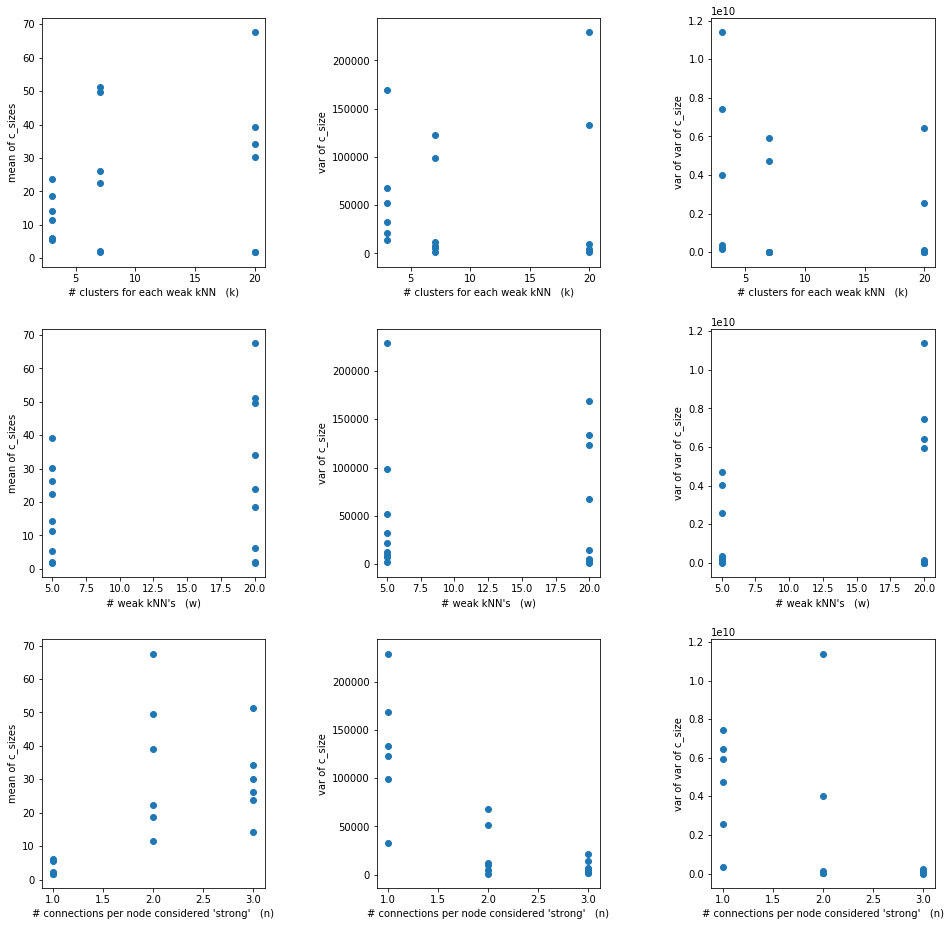

In [744]:
plt.rcParams['figure.figsize'] = (16,16)
k_stats = [[] for i in range(4)] # rows are: k,mean,var,var of var
weak_stats = [[] for i in range(4)]
neighbor_stats = [[] for i in range(4)]
for params,c_sizes in cluster_sizes.items():
    stats = (np.mean([len(a) for a in c_sizes]),np.mean([np.var(a) for a in c_sizes]),
             np.var([np.var(a) for a in c_sizes]))
    k_stats[0].append(params[0])
    weak_stats[0].append(params[1])
    neighbor_stats[0].append(params[2])
    for i in [0,1,2]:
        k_stats[i+1].append(stats[i])
        weak_stats[i+1].append(stats[i])
        neighbor_stats[i+1].append(stats[i])

_,subplt = plt.subplots(3, 3,gridspec_kw = {'wspace': 0.5,'hspace': 0.25}, sharey='col')
for row,d in enumerate([k_stats,weak_stats,neighbor_stats]):
    for col in range(3):
        subplt[row,col].scatter(d[0],d[col+1])

for i in [0,1,2]:
    subplt[0][i].set_xlabel('# clusters for each weak kNN   (k)')
    subplt[1][i].set_xlabel('# weak kNN\'s   (w)')
    subplt[2][i].set_xlabel("# connections per node considered 'strong'   (n)")
for i in [0,1,2]:
    subplt[i][0].set_ylabel('mean of c_sizes')
    subplt[i][1].set_ylabel('var of c_size')
    subplt[i][2].set_ylabel('var of var of c_size')

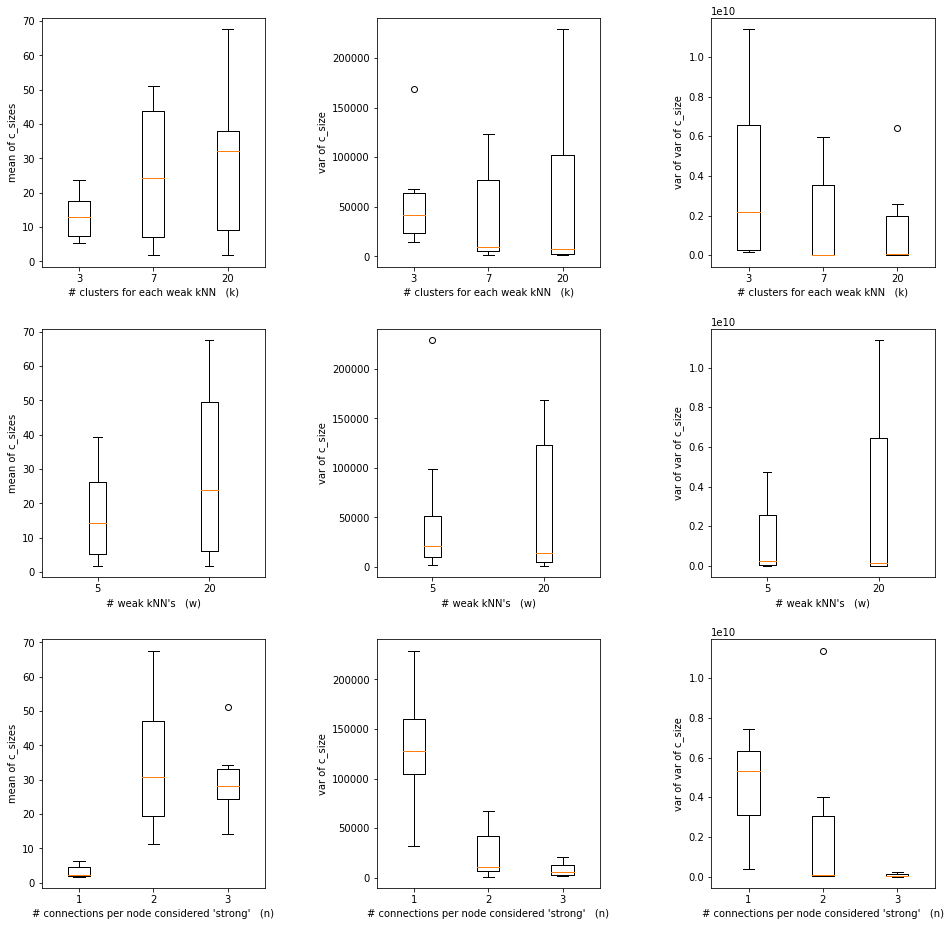

In [745]:
#k_stats_2 = [d[1] for k in [3,5,7,13,20] for i,d in enumerate(k_stats) if k_stats[0]==k  ]#,
k_stats_2 = [[[k_stats[1][i] for i in range(len(k_stats[1])) if k_stats[0][i]==k] for k in k_ticks],
             [[k_stats[2][i] for i in range(len(k_stats[1])) if k_stats[0][i]==k] for k in k_ticks],
             [[k_stats[3][i] for i in range(len(k_stats[1])) if k_stats[0][i]==k] for k in k_ticks]]
weak_stats_2 = [[[weak_stats[1][i] for i in range(len(weak_stats[1])) if weak_stats[0][i]==w] for w in w_ticks],
             [[weak_stats[2][i] for i in range(len(weak_stats[1])) if weak_stats[0][i]==w] for w in w_ticks],
             [[weak_stats[3][i] for i in range(len(weak_stats[1])) if weak_stats[0][i]==w] for w in w_ticks]]
neighbor_stats_2 = [[[neighbor_stats[1][i] for i in range(len(neighbor_stats[1])) if neighbor_stats[0][i]==n] for n in n_ticks],
             [[neighbor_stats[2][i] for i in range(len(neighbor_stats[1])) if neighbor_stats[0][i]==n] for n in n_ticks],
             [[neighbor_stats[3][i] for i in range(len(neighbor_stats[1])) if neighbor_stats[0][i]==n] for n in n_ticks]]
_,subplt = plt.subplots(3, 3,gridspec_kw = {'wspace': 0.5,'hspace': 0.25}, sharey='col')
for row,d in enumerate([k_stats_2,weak_stats_2,neighbor_stats_2]):
    for col in range(3):
        subplt[row,col].boxplot(d[col])
for i in [0,1,2]:
    subplt[0][i].set_xlabel('# clusters for each weak kNN   (k)')
    subplt[0][i].set_xticklabels(k_ticks)
    subplt[1][i].set_xlabel('# weak kNN\'s   (w)')
    subplt[1][i].set_xticklabels(w_ticks)
    subplt[2][i].set_xlabel("# connections per node considered 'strong'   (n)")
    subplt[2][i].set_xticklabels(n_ticks)
for i in [0,1,2]:
    subplt[i][0].set_ylabel('mean of c_sizes')
    subplt[i][1].set_ylabel('var of c_size')
    subplt[i][2].set_ylabel('var of var of c_size')


In [542]:
def get_regression_performance(predict_func,args,iterations,bias_factor=1):
    """
    predict_func: function that implements model. must return 3-tuple of rank 1 ndarrays, 
            (_, test true values, test predicted values)
    args: tuple of arguments for predict_func
    iterations: number of validation iterations desired 
    """
    #cum_stats = np.zeros((3,testSize)) # rows: 0.sum(prediction);  1.sum(prediction^2);  2.sum(pred-real)
    #bias = ( sum(pred - real) )^2 = ( sum(pred) - sum(real) )^2
    #var = sum(pred^2) - sum(pred) ^2
    for i in range(iterations):
        (y_true,y_pred,_) = predict_func(*args)
        if i == 0:
            cum_stats = np.zeros((3,len(y_pred)))
        cum_stats[0] += y_pred
        cum_stats[1] += (y_pred - y_true)
        cum_stats[2] += y_pred**2
    mean_y_pred = np.sum(cum_stats[0]) / cum_stats.shape[1]
    bias = np.sum(cum_stats[1]) / (cum_stats.shape[1]-1)
    variance = (np.sum(cum_stats[2]) - mean_y_pred**2) / (cum_stats.shape[1]-1)
    return (mean_y_pred, predict_func(*args)[2],(bias*bias_factor)**2 + variance)

In [ ]:
def get_regression_performance_shuffle_split(predict_func,data,goal,args,test_size=0.2,iterations=5,bias_factor=1):
    """
    predict_func: function that implements model. must return 3-tuple of rank 1 ndarrays, 
            (_, test true values, test predicted values)
    args: tuple of arguments for predict_func
    """
    
    for train_index, test_index in ShuffleSplit(n_splits=5, test_size=.2).split(data):
        (y_true,y_pred,_) = predict_func(data[train_index],data[test_index],goal[train_index],goal[test_index],*args)
        if i == 0:
            cum_stats = np.zeros((3,len(y_pred)))
        cum_stats[0] += y_pred
        cum_stats[1] += (y_pred - y_true)
        cum_stats[2] += y_pred**2
    mean_y_pred = np.sum(cum_stats[0]) / cum_stats.shape[1]
    bias = np.sum(cum_stats[1]) / (cum_stats.shape[1]-1)
    variance = (np.sum(cum_stats[2]) - mean_y_pred**2) / (cum_stats.shape[1]-1)
    return (mean_y_pred, predict_func(*args)[2],(bias*bias_factor)**2 + variance)

In [693]:
def lasso_prediction(x,y,alpha=1.0,rand_state=(np.random.rand(1) * 10000).astype(int),silent=True):
    train_x, valid_x, train_y, valid_y = train_test_split(
            x, y, test_size=0.2, random_state=rand_state)
        
    model = Lasso(alpha=alpha)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))

def lasso_prediction_pre_split(train_x, valid_x, train_y, valid_y,alpha=1.0,silent=True):   
    model = Lasso(alpha=alpha)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))


def ridge_prediction(x,y,alpha=1.0,rand_state=(np.random.rand(1) * 10000).astype(int),silent=True):
    train_x, valid_x, train_y, valid_y = train_test_split(
            x, y, test_size=0.2, random_state=rand_state)
        
    model = Ridge(alpha=alpha)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))
    
    
def ridge_prediction_pre_split(train_x, valid_x, train_y, valid_y,alpha=1.0,silent=True):

    model = Ridge(alpha=alpha)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))
    
    

    
def kNN_prediction(x,y,n_neighbors=5,rand_state=(np.random.rand(1) * 10000).astype(int),silent=True):
    train_x, valid_x, train_y, valid_y = train_test_split(
            x, y, test_size=0.2, random_state=rand_state)
        
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))
    

def kNN_prediction_pre_split(train_x, valid_x, train_y, valid_y,silent=True):
        
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))
    

    
def svr_prediction(x,y,kernel='rbf',rand_state=(np.random.rand(1) * 10000).astype(int), C=0.8,
                   epsilon=0.1,gamma='auto',silent=True):
    train_x, valid_x, train_y, valid_y = train_test_split(
            x, y, test_size=0.2, random_state=rand_state)
        
    model = SVR(kernel=kernel,C=C,epsilon=epsilon,gamma=gamma)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))
    
    
    
    
def adatree_prediction(x,y,depth=4,n_estimators=50,,rand_state=(np.random.rand(1) * 10000).astype(int),silent=True):
    train_x, valid_x, train_y, valid_y = train_test_split(
            x, y, test_size=0.2, random_state=rand_state)
        
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=depth),
                              n_estimators=n_estimators,random_state=rand_state)
    model.fit(train_x,train_y)
    y_pred = model.predict(valid_x)
    if not silent:
        plt.rcParams['figure.figsize'] = (5,2)
        plt.title(str(alpha))
        plt.violinplot(y_pred-valid_y, vert = False, showmeans=True, showextrema=True, showmedians=True)
    return(valid_y, y_pred, pickle.dumps(model))
    


SyntaxError: invalid syntax (<ipython-input-693-5ebaafb74f03>, line 80)

In [550]:
def get_regression(data, goal, bias_factor, lasso=True, ridge=True, 
                   kNN=True, svr=True, adatree=True):
    #rand_states = [1213,239485,7298345,143542,535]
    regression_options = [] # store tuples of (pickled model, error)
    if lasso:
        lst_alpha = [0.4,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,1,1.1]
        for alpha in lst_alpha:
            best = (None,1000000000000000000)
            args = (alpha,)
            _,pickled_model, model_score = get_regression_performance_shuffle_split(lasso_prediction_pre_split,data,
                                                                                        goal,args,
                                                                                        bias_factor=bias_factor)
            best = (best if (best[1] <= model_score) else (pickled_model,model_score))
        regression_options.append(best)

    if ridge:
        lst_alpha = [0.4,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,1,1.1]
        for alpha in lst_alpha:
            best = (None,1000000000000000000)
            args = (alpha,)
            _, pickled_model, model_score = get_regression_performance_shuffle_split(ridge_prediction_pre_split,args,
                                                        bias_factor=bias_factor)
            best = (best if (best[1] <= model_score) else (pickled_model,model_score))
        regression_options.append(best)
        
    if kNN:
        if len(data) > 75: # otherwise kNN regression is probably not effective
            lst_n = np.arange(3,10)
            for n in lst_n:
                best = (None,1000000000000000000)
                args = (n,)
                _, pickled_model, model_score = get_regression_performance_shuffle_split(kNN_prediction_pre_split,data,
                                                                                     goal,args,
                                                                                    bias_factor=bias_factor)
                best = (best if (best[1] <= model_score) else (pickled_model,model_score))
            regression_options.append(best)
        
        
    if svr:
        lst_kernel=['rbf','linear']
        lst_C= [0.1,0.5,1,5,10,50,100]
        lst_epsilon = [0.01,0.03,0.05,0.07,0.1]
        lst_gamma = [0.001,0.005,0.01,0.05,0.1]
        combos = itertools.product(lst_kernel,lst_C,lst_epsilon)
        for comb in combos:
            args = (data,goal,*comb)
            _, pickled_model, model_score = get_regression_performance(svr_prediction,args,
                                                    iterations=5,bias_factor=bias_factor)
            best = (best if (best[1] <= model_score) else (pickled_model,model_score))
        regression_options.append(best)
        
    if adatree:
        lst_depth=np.arange(2,6)
        lst_weak=[10,50,100]
        combos = itertools.product(lst_depth,lst_weak)
        for comb in combos:
            args = (data,goal,*comb)
            _, pickled_model, model_score = get_regression_performance(adatree_prediction,args,
                                                        iterations=5,bias_factor=bias_factor)
            best = (best if (best[1] <= model_score) else (pickled_model,model_score))
        regression_options.append(best)
        
    return regression_options, regression_options[np.argmin(tup[1] for tup in regression_options)]

In [545]:
# estimate most similar cluster (using purely intuition)
def find_cluster(d,cluster_stats):
    return np.argmin([np.sum( (d - stat[0]) / (stat[1] * (d-stat[0])**(stat[2]*stat[3])) )  for stat in cluster_stats])

In [ ]:
def regress_overall_stacked(features, goal, test_size, r_state=(np.random.rand(1) * 10000).astype(int),
                               lasso=True, ridge=True, kNN=True, svm=True, adatree=True,silent=False):
    

    _, pickled_overall_weak = get_regression(data,goal,1,ridge=False)
    overall_weak = [pickle.loads(d) for d in pickled_overall_weak]
    
    train, valid, train_goal_true, valid_goal_true = train_test_split(
                        features,goal,test_size=test_size,random_state=r_state)
    
    overall_weak_pred_train = []
    for weak in overall_weak:
        weak.fit_predict(train,train_goal)
        overall_weak_pred_train.append(weak.predict(train))
    pred_input = np.vstack(overall_weak_pred_train)
    overall_stack = LogisticRegression()
    overall_stack.fit(pred_input, train_goal)
    overall_pred = overall_stack.predict(valid)
    
    overall_SSE += mean_squared_error(valid_goal.values, overall_pred)
    overall_r2 += r2_score(valid_goal.values, overall_pred)
 
    if not silent:
        print("Ensemble model without clustering SSE: %f" % overall_SSE)
        print("Ensemble model without clustering r2: %0.4f" % overall_r2)
        print("")
    
    

In [606]:
def regress_by_cluster(features, goal, test_size, r_state=rand_state=(np.random.rand(1) * 10000).astype(int)
                               lasso=True, ridge=True, kNN=True, svm=True, adatree=True,silent=False):
    

    _, pickled_overall_weak = get_regression(data,goal,1,ridge=False)
    overall_weak = [pickle.loads(d) for d in pickled_overall_weak]
    
    train, valid, train_goal_true, valid_goal_true = train_test_split(
                        features,goal,test_size=test_size,random_state=r_state)
    
    overall_weak_pred_train = []
    for weak in overall_weak:
        overall_weak_pred_train.append(weak.fit_predict(train,train_goal))
    pred_input = np.vstack(overall_weak_pred_train)
    overall_stack = LogisticRegression()
    overall_stack.fit(pred_input, train_goal)
    overall_pred = overall_stack.predict(valid)
    
    overall_weak_pred = [weak.predict(valid) for weak in overall_weak]
    overall_weak_scores = [(type(weak), mean_squared_error(valid_goal.values, overall_weak_pred[i]),
                        r2_score(valid_goal.values, overall_weak_pred[i])) for i,weak in enumerate(overall_weak)]    
    overall_SSE += mean_squared_error(valid_goal.values, overall_pred)
    overall_r2 += r2_score(valid_goal.values, overall_pred)

    clusters = list(cluster_from_stack_of_KMeans(train, K=3, num_weak_learners = 20,num_neighbors=20))
    cluster_stats = np.empty((len(clusters),4,len(train.columns))) #dim2=mean,var,skew,kurtosis
    for i,cluster in enumerate(clusters):
        lst = list(cluster)
        cluster_stats[i,0,:] = np.mean(lst)
        cluster_stats[i,1,:] = np.std(lst)
        cluster_stats[i,2,:] = skew(lst)
        cluster_stats[i,3,:] = kurtosis(lst)

    #####
    if not silent:
        for i,d in enumerate(clusters):
            print("cluster size: " + str(len(d)))
            display (pd.DataFrame(cluster_stats[i],columns=['mean','var','skew','kurtosis']))
            print('\n')
    #####

    cluster_regressions = []

    for c in clusters:
        if (len(c) > 30):
            bias_factor=1
            #bias_factor = (1 if len(c) > 100 else (len(c)+100)/200)
            lst_c = list(c)
            #reg_options=get_regression(train.iloc[lst_c], train_goal.iloc[lst_c], bias_factor)
            #cluster_regressions.append(reg_options[np.argmin(tup[1] for tup in reg_options)])
            cluster_regressions.append(get_regression(train.iloc[lst_c], train_goal.iloc[lst_c], 
                                                      bias_factor,ridge=False))
        else:
            cluster_regressions.append(None)

    valid_clusters = [find_cluster(i[1],cluster_stats) for i in valid.iterrows()]

    y_pred = []
    for i,d in enumerate(valid.iterrows()):
        if not cluster_regressions[valid_clusters[i]] is None:
            cluster_prediction = pickle.loads((cluster_regressions[valid_clusters[i]])[0]).predict(d[1].values.reshape(1,-1))
            overall_prediction = overall_model.predict(d[1].values.reshape(1,-1))
            cluster_factor = 1 / (2 + 5 * math.exp(-len(clusters[valid_clusters[i]])/100))
            y_pred.append(cluster_prediction*cluster_factor + overall_prediction*(1-cluster_factor))
        else:
            y_pred.append(overall_model.predict(d[1].values.reshape(1,-1)))
    
    
    total_ensemble_SSE = mean_squared_error(valid_goal.values, y_pred)
    total_ensemble_r2 = r2_score(valid_goal.values, y_pred)
 
    if not silent:
        print("Overall weak, SSE, r2:")
        print(overall_weak_scores)
        print("Ensemble model without clustering SSE: %f" % overall_SSE)
        print("Ensemble model without clustering r2: %0.4f" % overall_r2)
        print("Total Ensemble model SSE: %f" % total_ensemble_SSE)
        print("Total Ensemble model r2: %0.4f" % total_ensemble_r2)
        print("")
    
    

In [ ]:
print(get_regression_performance(regress_overall_stacked,(data[final_features], data['SalePrice'], 0.2),iterations=5,bias_factor=1)):

In [672]:
print(get_regression_performance(regress_by_cluster,(data[final_features], data['SalePrice'], 0.2),iterations=5,bias_factor=1):

190325167167.65564
